In [363]:
#!pip install joypy

In [364]:
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
from sklearn.preprocessing import StandardScaler
import networkx as nx
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from joypy import joyplot
from matplotlib import cm

In [365]:
data_matrix = pd.read_csv('GSE149428_Source_Data_File_2_lncap_expression.csv')


In [366]:
data_matrix.set_index('Gene', inplace=True)

In [367]:

# Creating a DataFrame
df = data_matrix

# Function to average columns with similar prefixes
def average_columns(df, prefix):
    # Filter columns starting with the given prefix
    columns = [col for col in df if col.startswith(prefix)]
    # Average the selected columns
    df[f'{prefix}'] = df[columns].mean(axis=1)

# List of unique prefixes
prefixes = set(col.split('A')[0] for col in df.columns if 'A' in col)

# Averaging columns for each prefix
for prefix in prefixes:
    average_columns(df, prefix)

df=df.iloc[:,144:]

In [368]:

def custom_sort(column_names):
    # Split the column name into prefix and number, converting the number part to integer
    sorted_columns = sorted(column_names, key=lambda x: (x.split('_')[0], int(x.split('_')[1])))
    return sorted_columns

sorted_columns = custom_sort(prefixes)

In [369]:
df=df[sorted_columns]

In [370]:
data_matrix=df.T

In [371]:
variances = data_matrix.var()

high_variance_genes = variances.sort_values(ascending=False)[0:1000].index

In [372]:
data_matrix=data_matrix[high_variance_genes]

In [373]:
data_matrix=data_matrix/3

In [374]:
layout=pd.read_csv('layout_GSE149428.csv')

In [375]:
layout.index=layout['Unnamed: 0'].values

In [376]:
layout=layout.drop(['Unnamed: 0'],axis=1)

In [377]:
data_normalized=data_matrix[layout.index]

In [378]:
data_normalized=data_normalized.T


In [379]:
data_normalized=data_normalized[['DMSO_0', 'DMSO_3', 'DMSO_6', 'DMSO_9', 'DMSO_12', 'DMSO_24', 'M_0',
       'M_3', 'M_6', 'M_9', 'M_12', 'M_24',  'T_0', 'T_3', 'T_6', 'T_9', 'T_12', 'T_24', 'W_0', 'W_3', 'W_6', 'W_9', 'W_12', 'W_24','TM_0',
       'TM_3', 'TM_6', 'TM_9', 'TM_12', 'TM_24','TW_0', 'TW_3', 'TW_6', 'TW_9', 'TW_12',
       'TW_24', 'MW_0', 'MW_3', 'MW_6', 'MW_9',
       'MW_12', 'MW_24','TMW_0', 'TMW_3', 'TMW_6',
       'TMW_9', 'TMW_12', 'TMW_24']]

In [380]:
def gaussian_2D(value, x, y, x0, y0, s=1.0):
    return value * np.exp(-((x - x0)**2  + (y - y0)**2) / (s**2))

def add_gaussian_to_total(params):
    value, x0, y0, sx = params
    return gaussian_2D(value, x, y, x0, y0, sx)

In [381]:

outGT = []
outGT_name = []
res = 200
sigma = 0.05

# Create grid
x = np.linspace(0, 1, res)
y = np.linspace(0, 1, res)
x, y = np.meshgrid(x, y)

#df.index=cluster.index
timeline= ['0 hour','3 hour','6 hour','9 hour','12 hour','24 hour']*8
itr=0
for name in data_normalized:

        data_cluster = data_normalized[name]
        z_total = np.zeros_like(x)
        params = zip(data_cluster, layout['X'], layout['Y'], [sigma]*layout.shape[0])

        with ThreadPoolExecutor() as executor:
            results = executor.map(add_gaussian_to_total, params)
            for z in results:
                z_total += z

        mat = z_total.reshape(1, -1)
        outGT.append(mat)
        outGT_name.append(name)

        #plt.figure()
        #plt.imshow(mat.reshape(res, res), origin='lower', cmap='jet', vmin=-20, vmax=20)
        #plt.colorbar()
        #plt.title(timeline[itr])
        #plt.savefig(f'plot1/{name}.png', bbox_inches='tight')
        #plt.close()
        #itr=itr+1

outGT = np.reshape(outGT, (len(outGT), -1))


In [382]:
#!zip -r plot_Cell_line_GSE149428_MCBIOS2024.zip plot1

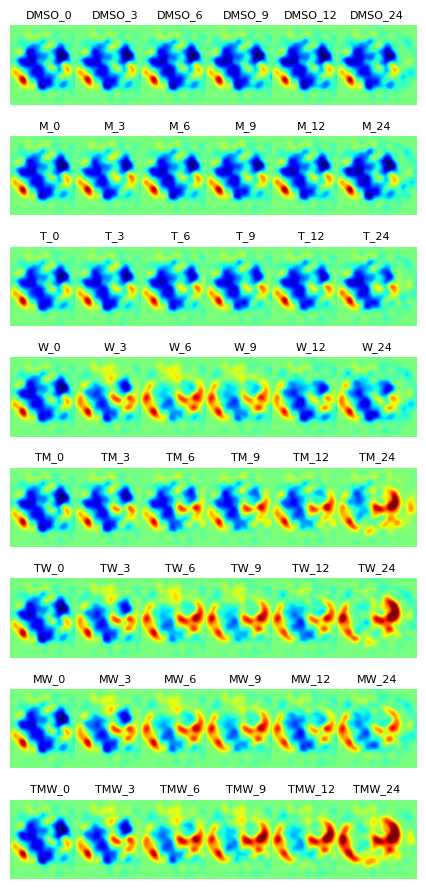

In [383]:
import matplotlib.pyplot as plt



# Create a figure and a set of subplots with 8 rows and 6 columns.
fig, axes = plt.subplots(nrows=8, ncols=6, figsize=(15, 9))

# Define some titles for each subplot
titles = data_normalized.columns

# Define a unique colormap for each image
colormaps = 48 * ['jet']

# Iterate over each subplot, image matrix, title, and colormap to display them.
for i, (ax, title, colormap) in enumerate(zip(axes.flat, titles, colormaps)):
    mat = outGT[i, :]
    image_matrices = mat.reshape(res, res)
    im = ax.imshow(image_matrices, origin='lower', cmap='jet', vmin=-20, vmax=20)
    ax.set_title(title, fontsize=8)
    ax.axis('off')



# Adjust subplot spacing to ensure figures are attached together
plt.subplots_adjust(bottom=0.15, wspace=-1)  # No space between subplots

plt.tight_layout()
plt.show()


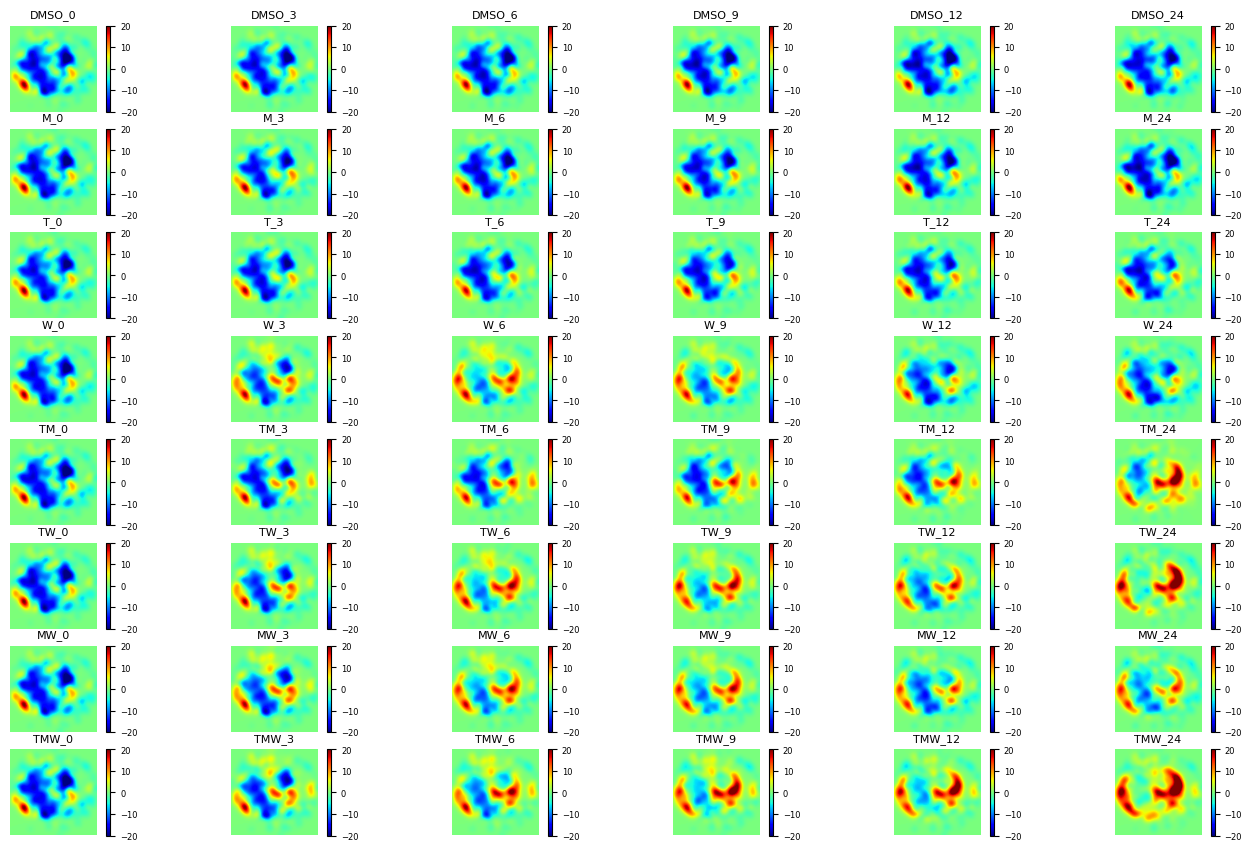

In [384]:
import matplotlib.pyplot as plt
import matplotlib as mpl



# Create a figure and a set of subplots with 8 rows and 6 columns, specifying margins
fig, axes = plt.subplots(nrows=8, ncols=6, figsize=(15, 9),
                         subplotpars=mpl.figure.SubplotParams(left=0.05, right=0.95, bottom=0.05, top=0.95,
                                                              wspace=-.1, hspace=0.2))

# Define some titles for each subplot
titles = data_normalized.columns

# Define a unique colormap for each image
colormaps = 48 * ['jet']

# Iterate over each subplot, image matrix, title, and colormap to display them.
for i, (ax, title, colormap) in enumerate(zip(axes.flat, titles, colormaps)):
    mat = outGT[i, :]
    image_matrices = mat.reshape(res, res)
    im = ax.imshow(image_matrices, origin='lower', cmap='jet', vmin=-20, vmax=20)
    ax.set_title(title, fontsize=8)
    ax.axis('off')
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.yaxis.label.set_size(8)
    cbar.ax.tick_params(labelsize=6)

plt.show()

# **Tracking Genes**



In [385]:
def subtract_matrices(matrix1, matrix2):
    return np.subtract(matrix1, matrix2)

def find_high_variation_indices(diff_matrix, threshold):
    high_variation_indices = np.argwhere(np.abs(diff_matrix) > threshold)
    return high_variation_indices


In [386]:
data_normalized.columns[24]

'TM_0'

**Sensitive genes between 0 hours and 3 hours in TMW drug based on Temporal GeneTerrain**

In [387]:
mat_TMW0 = outGT[42, :]
mat_TMW3 = outGT[43, :]
mat_TMW0 = mat_TMW0.reshape(200, 200)
mat_TMW3 = mat_TMW3.reshape(200, 200)

diff_matrix = subtract_matrices(mat_TMW0, mat_TMW3)


In [388]:
layout1=np.round(200*layout).astype(int)
layout1

,X,Y
HMOX1,132,75
HSPA6,93,53
TREML3P,126,149
GCNT3,157,104
SLC30A2,185,92
...,...,...
CASC10,110,80
TLR2,142,58
SFMBT2,147,105
TNFSF10,43,87


In [389]:
mat_TMW3 = outGT[42, :]
mat_TMW6 = outGT[43, :]
mat_TMW3 = mat_TMW3.reshape(200, 200)
mat_TMW6 = mat_TMW6.reshape(200, 200)

diff_matrix = subtract_matrices(mat_TMW3, mat_TMW6)

### ** Plot for upregulate and downregulate in Temproral GeneTerrain**

In [390]:
for i in range(0,48):
  mat = outGT[i, :]
  signal_value_up =  np.sum([value for value in mat if value > 5])
  signal_value_down =  np.sum([value for value in mat if value < 5])
  print(outGT_name[i],round(signal_value_up),round(signal_value_down))

DMSO_0 11649 -130472
DMSO_3 11656 -124995
DMSO_6 10876 -136541
DMSO_9 10923 -136949
DMSO_12 9953 -147433
DMSO_24 10827 -135886
M_0 11547 -131678
M_3 14876 -101365
M_6 12929 -125006
M_9 13803 -118027
M_12 14018 -125999
M_24 12106 -151385
T_0 11768 -121842
T_3 12923 -113629
T_6 13472 -107668
T_9 14427 -102621
T_12 14338 -108265
T_24 15140 -105924
W_0 11790 -126350
W_3 31045 -62207
W_6 50491 -30981
W_9 40519 -41077
W_12 18197 -95873
W_24 19621 -99105
TM_0 11554 -131440
TM_3 20604 -92170
TM_6 27268 -70629
TM_9 32503 -62497
TM_12 36973 -46405
TM_24 72334 -6008
TW_0 11495 -130604
TW_3 27613 -68910
TW_6 56601 -28034
TW_9 52747 -26799
TW_12 41584 -54733
TW_24 83754 -8027
MW_0 12181 -124113
MW_3 30885 -63717
MW_6 49478 -34262
MW_9 48035 -34530
MW_12 30917 -66987
MW_24 40120 -51415
TMW_0 11553 -128819
TMW_3 29978 -65318
TMW_6 51120 -33076
TMW_9 65750 -15686
TMW_12 64903 -19527
TMW_24 111238 11380


In [391]:
data_normalized.columns[29]

'TM_24'

In [392]:
mat = outGT[24, :]
mat = mat.reshape(200, 200)

In [393]:
def find_matching_indices(layout_matrix, index_array):
    matches = []
    for idx, (x, y) in enumerate(index_array):
        if ((layout_matrix['X'] == x) & (layout_matrix['Y'] == y)).any():
            matches.append([x,y])  # Storing the index of the matching pair
    return matches

# Find matches
#matching_indices = find_matching_indices(layout1, np.argwhere(mat < 0))

#print("Matching indices:", matching_indices)
def find_row_indices_in_dataframe(df, coordinates):
    row_indices = []
    for x, y in coordinates:
        matched_rows = df.index[(df['X'] == x) & (df['Y'] == y)].tolist()
        row_indices.extend(matched_rows)
    return row_indices

# Assuming layout1 is your DataFrame and matching_indices is the list of [X, Y] pairs
#row_indices = find_row_indices_in_dataframe(layout1, matching_indices)

#print("Row indices in layout1:", row_indices)

In [394]:
import matplotlib.pyplot as plt


In [395]:
mat = outGT[29, :]
mat = mat.reshape(200, 200)
matching_indices = find_matching_indices(layout1, np.argwhere(mat[50:150,85:165] > 0))
row_indices = find_row_indices_in_dataframe(layout1, matching_indices)

Text(0.5, 1.0, 'TMW_24')

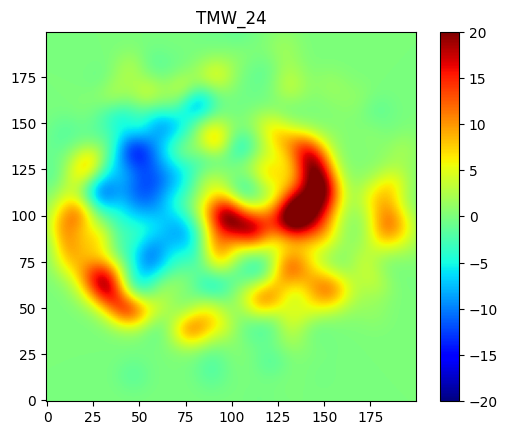

In [396]:
plt.style.use('default')

plt.figure()
plt.imshow(mat, origin='lower', cmap='jet', vmin=-20, vmax=20)
plt.colorbar()
plt.title(name)


In [397]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from PIL import Image

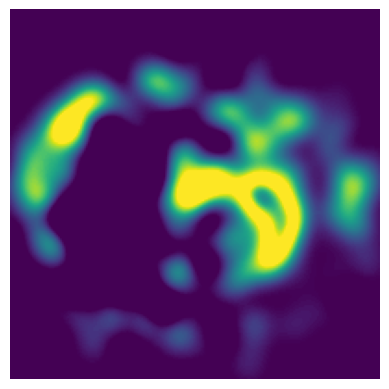

In [398]:


# Create a sample 2D matrix
matrix = mat  # A 10x10 matrix of random values

# Normalize the matrix to the range [0, 1]
norm = Normalize(vmin=matrix.min(), vmax=matrix.max())
normalized_matrix = norm(matrix)

# Apply the colormap directly to the normalized matrix
cmap = plt.get_cmap('jet')  # Choose the same colormap used in imshow
colored_image = cmap(normalized_matrix)

# The colored image will have RGBA channels, so we need to convert it to RGB
rgb_image = (colored_image[..., :3] * 255).astype(np.uint8)
img = Image.fromarray(rgb_image)

# Display the RGB image
plt.imshow(rgb_image[:,:,0])
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

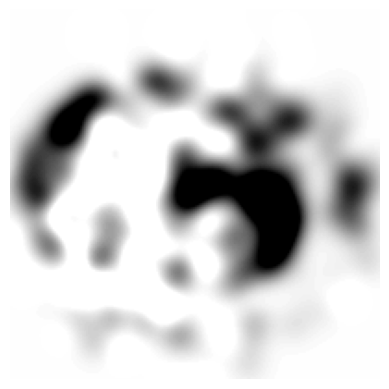

In [399]:
# Display the RGB image
plt.imshow(rgb_image[:,:,2],cmap='gray')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [400]:
import cv2


In [401]:
mat=(mat-np.min(mat))/(np.max(mat)-np.min(mat));

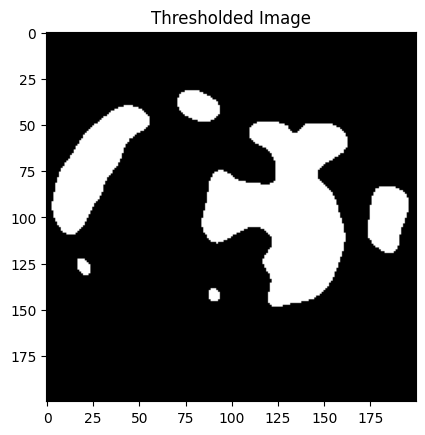

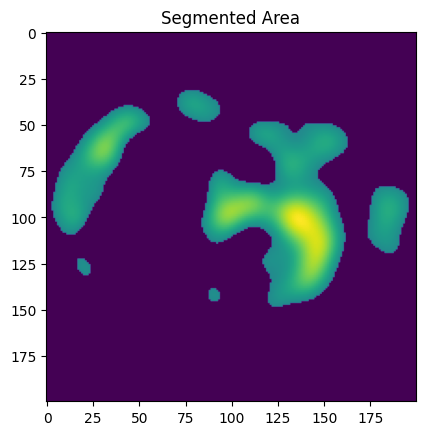

In [402]:
# Convert the image to grayscale

gray_image = np.round(255*mat).astype(np.uint8);



# Apply a threshold to segment the area

# Using Otsu's thresholding method to automatically determine the best threshold value

_, thresholded_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)



# Display the thresholded image

plt.imshow(thresholded_image, cmap='gray')

plt.title('Thresholded Image')

plt.show()



# Now, let's create a mask from the thresholded image and apply it to the original image

# to extract the segmented area.

mask = thresholded_image > 0  # Creating a boolean mask



# Create an all-zeros image with the same dimensions as the original image

segmented_area = np.zeros_like(gray_image)



# Copy the area of interest from the original image using the mask

segmented_area[mask] = gray_image[mask]



# Display the segmented area

plt.imshow(segmented_area)

plt.title('Segmented Area')

plt.show()

In [403]:
num_labels, labels_im = cv2.connectedComponents(thresholded_image)


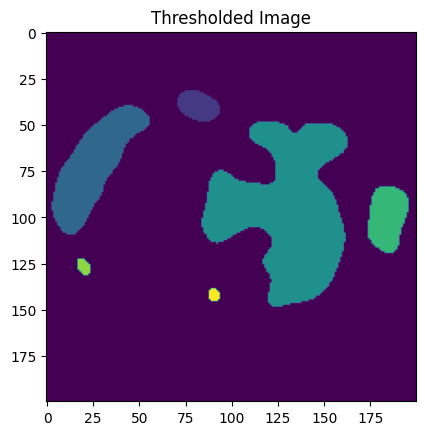

In [404]:
# Display the thresholded image

plt.imshow(labels_im)

plt.title('Thresholded Image')

plt.show()

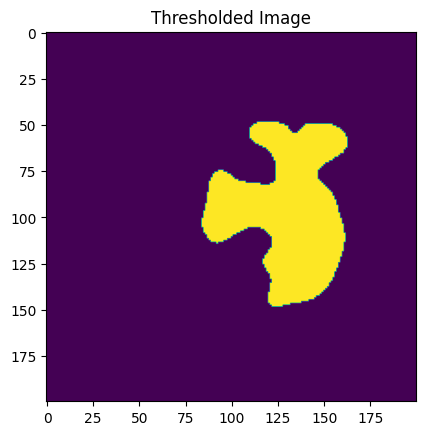

In [405]:
# Display the thresholded image

plt.imshow(labels_im==3)

plt.title('Thresholded Image')

plt.show()

In [406]:
range(0,len(outGT),5)

range(0, 48, 5)

In [407]:
matching_indices = find_matching_indices(layout1, np.argwhere(labels_im==6))
row_indices = find_row_indices_in_dataframe(layout1, matching_indices)

In [408]:
matching_indices = find_matching_indices(layout1, np.argwhere(labels_im==3))
row_indices = find_row_indices_in_dataframe(layout1, matching_indices)

In [409]:
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error


# **Plot of Different Treatments vs. Control in Region A**

In [410]:
intensity_24=[]
for i in range(5,len(outGT),6):
    print(outGT_name[i])
    mat = outGT[i, :]
    mat = mat.reshape(200, 200)
    #mat=(mat-np.min(mat))/(np.max(mat)-np.min(mat));
    #mat=2*mat-1
    intensity_24.append(mat[labels_im==3])

DMSO_24
M_24
T_24
W_24
TM_24
TW_24
MW_24
TMW_24


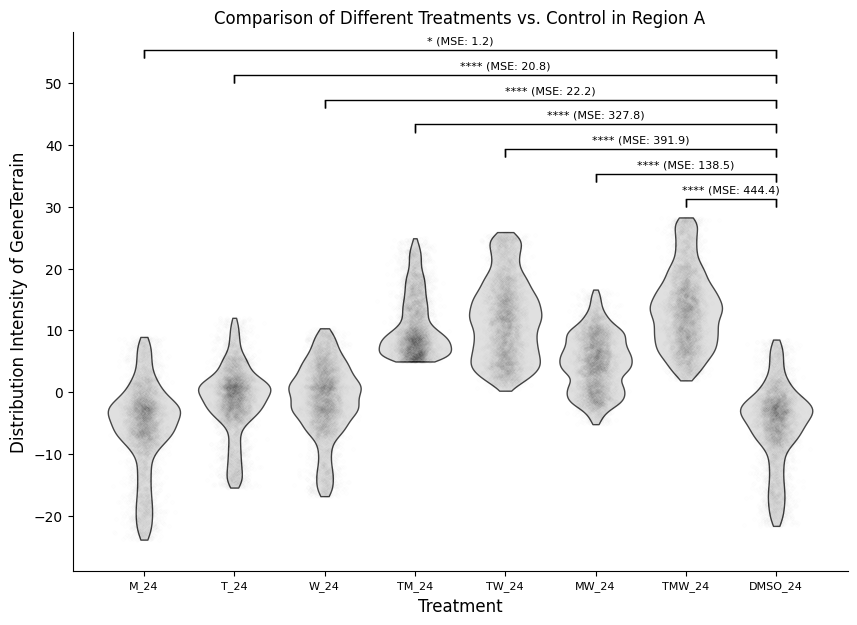

In [411]:
all_dht_data = intensity_24[1:]

veh_data=intensity_24[0]
p_values = [ttest_ind(dht_data, veh_data).pvalue for dht_data in all_dht_data]
# Calculate p-values for comparisons (using a simple t-test here for the example)

# Assuming all_dht_data is a list of arrays and veh_data is an array
mse_values = [mean_squared_error(dht_data, veh_data) for dht_data in all_dht_data]

# Set style to a neutral color for the plot
#plt.style.use('seaborn-whitegrid')

plt.style.use('default')
#plt.style.use('ggplot')

# Customize colors of the violin plots to neutral

neutral_color = '#D3D3D3'  # A common neutral color (light gray)

# Create a new figure with adjusted size
plt.figure(figsize=(10, 7))

# Create violin plots for each DHT group and the VEH group
positions = [1, 2, 3, 4, 5,6,7,8]  # Positions on the x-axis
vp = plt.violinplot(all_dht_data + [veh_data], positions=positions, widths=0.8, showmeans=False, showmedians=False, showextrema=False)

# Customize colors of the violin plots to neutral
for pc in vp['bodies']:
    pc.set_facecolor(neutral_color)
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Adding scatter for the actual data points with smaller size
#scatter_positions = np.repeat(positions, [len(d) for d in all_dht_data] + [len(veh_data)])
scatter_data = np.concatenate(all_dht_data + [veh_data])
#plt.scatter(scatter_positions, scatter_data, color='black', alpha=0.2, s=1)
ax = plt.gca()

for i, data in enumerate(all_dht_data + [veh_data], 1):

    y = data

    x = np.random.normal(i, 0.1, size=len(y))

    ax.plot(x, y, 'k.', alpha=0.005)
# Remove top and right axis lines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adding the significance annotations for p-values and lines for more clarification
ymax = max(scatter_data) + 0.05
ymin = min(scatter_data) - 0.05
pval1=[]
for pval in p_values:
  if pval < 0.00001:
    pval = '****'
  elif pval < 0.0001:
    pval = '***'
  elif pval < 0.001:
    pval = '**'
  elif pval < 0.05:
    pval = '*'
  else:
     pval = 'ns'
  pval1.append(pval)
# Draw horizontal lines for each p-value annotation
for i, p_value in enumerate(pval1, 1):
    y_line = ymax + 27 + (1-i)*4  # increment y position for each line to avoid overlap
    plt.text((positions[i-1]+positions[-1])/2, round(y_line)+1, p_value+ ' (MSE: '+str(np.round(mse_values[i-1],1))+')', ha='center', va='bottom', fontsize=8)
    plt.plot([i, 8], [y_line, y_line], color="black", lw=1)
    plt.plot([i, i], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

    plt.plot([positions[-1], positions[-1]], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

# Set axis labels with a larger font size
plt.xticks(positions, ['M_24','T_24','W_24','TM_24','TW_24', 'MW_24', 'TMW_24',  'DMSO_24'], fontsize=8)
plt.ylabel('Distribution Intensity of GeneTerrain', fontsize=12)
plt.ylim(ymin-5, ymax + 30)  # Adjust the y-axis limit to accommodate annotation
plt.rcParams['figure.facecolor'] = 'white'
plt.xlabel('Treatment', fontsize=12,)
plt.title("Comparison of Different Treatments vs. Control in Region A")
plt.rcParams['axes.facecolor'] = 'white'
# Show the plot with the adjusted style
plt.show()

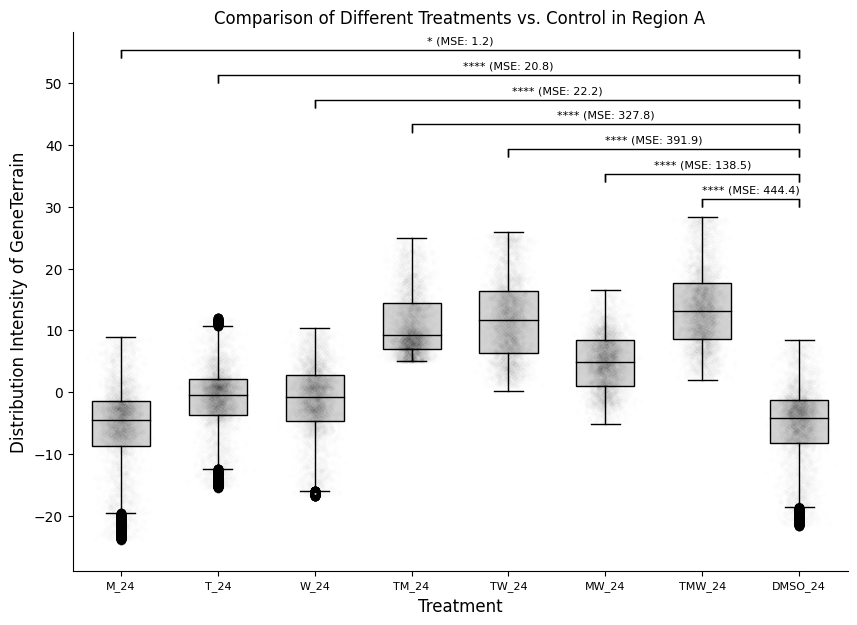

In [412]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem, ttest_ind
from sklearn.metrics import mean_squared_error

# Your data setup
all_dht_data = intensity_24[1:]
veh_data = intensity_24[0]
p_values = [ttest_ind(dht_data, veh_data).pvalue for dht_data in all_dht_data]
mse_values = [mean_squared_error(dht_data, veh_data) for dht_data in all_dht_data]

# Set style to default
plt.style.use('default')

# Create a new figure with adjusted size
plt.figure(figsize=(10, 7))

# Create box plots for each DHT group and the VEH group
positions = np.arange(1, len(all_dht_data) + 2)  # Positions on the x-axis

# Draw box plots and capture the returned dictionary
boxprops = dict(color="black", linestyle="-")
whiskerprops = dict(color="black", linestyle="-")
capprops = dict(color="black")
medianprops = dict(color="black", linestyle="-")
flierprops = dict(marker='o', color='black', alpha=0.5)

bp = plt.boxplot(all_dht_data + [veh_data], positions=positions, widths=0.6, patch_artist=True,
                 boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops, flierprops=flierprops)

# Change the face color of the boxes
for box in bp['boxes']:
    box.set(facecolor = '#D3D3D3')  # Light gray color
scatter_data = np.concatenate(all_dht_data + [veh_data])
#plt.scatter(scatter_positions, scatter_data, color='black', alpha=0.2, s=1)
ax = plt.gca()

for i, data in enumerate(all_dht_data + [veh_data], 1):

    y = data

    x = np.random.normal(i, 0.1, size=len(y))

    ax.plot(x, y, 'k.', alpha=0.005)

# Adding the significance annotations for p-values and lines for more clarification
ymax = max(scatter_data) + 0.05
ymin = min(scatter_data) - 0.05
pval1=[]
for pval in p_values:
  if pval < 0.00001:
    pval = '****'
  elif pval > 0.00001 and pval< 0.0001:
    pval = '***'
  elif pval > 0.0001 and pval< 0.001:
    pval = '**'
  elif pval > 0.001 and pval < 0.05:
    pval = '*'
  elif pval > 0.05:
    pval = 'ns'
  #else:
     #pval = 'ns'
  pval1.append(pval)
# Draw horizontal lines for each p-value annotation
for i, p_value in enumerate(pval1, 1):
    y_line = ymax + 27 + (1-i)*4  # increment y position for each line to avoid overlap
    plt.text((positions[i-1]+positions[-1])/2, round(y_line)+1, p_value+ ' (MSE: '+str(np.round(mse_values[i-1],1))+')', ha='center', va='bottom', fontsize=8)
    plt.plot([i, 8], [y_line, y_line], color="black", lw=1)
    plt.plot([i, i], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

    plt.plot([positions[-1], positions[-1]], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

# Set axis labels with a larger font size
plt.xticks(positions, ['M_24','T_24','W_24','TM_24','TW_24', 'MW_24', 'TMW_24',  'DMSO_24'], fontsize=8)
plt.ylabel('Distribution Intensity of GeneTerrain', fontsize=12)
plt.ylim(ymin-5, ymax + 30)  # Adjust the y-axis limit to accommodate annotation
plt.rcParams['figure.facecolor'] = 'white'
plt.xlabel('Treatment', fontsize=12,)
plt.title("Comparison of Different Treatments vs. Control in Region A")
plt.rcParams['axes.facecolor'] = 'white'

# Remove top and right axis lines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Show the plot with the adjusted style
plt.show()

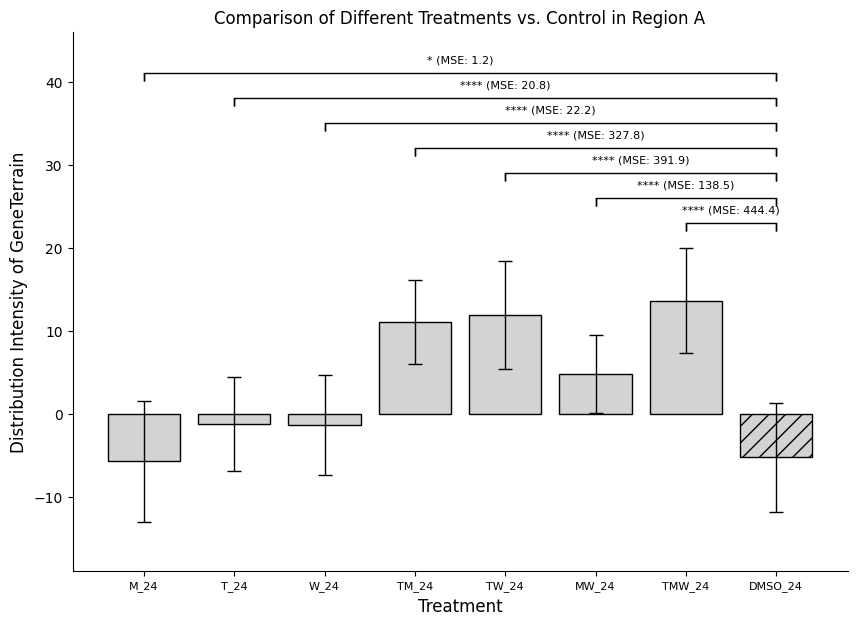

In [413]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'all_dht_data' and 'veh_data' are defined earlier in your code
# and 'positions', 'neutral_color', 'pval1', 'mse_values', 'ymin' are also predefined

# Generating mean and standard deviation for each group for the bar chart
mean_dht_data = [np.mean(dht) for dht in all_dht_data]
std_dht_data = [np.std(dht, ddof=1) for dht in all_dht_data]  # Using sample standard deviation
mean_veh_data = np.mean(veh_data)
std_veh_data = np.std(veh_data, ddof=1)  # Using sample standard deviation

# Set the background to white
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Create a new figure with adjusted size
plt.figure(figsize=(10, 7))

# Adjusting positions to match the number of DHT groups plus the VEH group
# Assuming 'positions' is a list of positions for each group
bar_positions_dht = positions[:-1]  # Use all but the last position for DHT groups
bar_positions_veh = positions[-1]  # Use the last position for the VEH group

# Plot bars for DHT groups
plt.bar(bar_positions_dht, mean_dht_data, yerr=std_dht_data, color=neutral_color, capsize=5, edgecolor='black', error_kw=dict(elinewidth=1, ecolor='black'))

# Plot bar for VEH group as a single bar, turning mean and std into lists to match the expected format
plt.bar([bar_positions_veh], [mean_veh_data], yerr=[std_veh_data], color=neutral_color, capsize=5, edgecolor='black', hatch="//", error_kw=dict(elinewidth=1, ecolor='black'))
# Adding the significance annotations for p-values
ymax = max(mean_dht_data + [mean_veh_data]) + max(std_dht_data + [std_veh_data]) + 0.1

# Draw horizontal lines for each p-value annotation
for i, p_value in enumerate(pval1, 1):
    y_line = ymax + 20 + (1-i)*3  # increment y position for each line to avoid overlap
    plt.text((positions[i-1]+positions[-1])/2, round(y_line)+1, p_value+ ' (MSE: '+str(np.round(mse_values[i-1],1))+')', ha='center', va='bottom', fontsize=8)
    plt.plot([i, 8], [y_line, y_line], color="black", lw=1)
    plt.plot([i, i], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

    plt.plot([positions[-1], positions[-1]], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

# Set axis labels with a larger font size
plt.xticks(positions, ['M_24','T_24','W_24','TM_24','TW_24', 'MW_24', 'TMW_24',  'DMSO_24'], fontsize=8)
plt.ylabel('Distribution Intensity of GeneTerrain', fontsize=12)
plt.ylim(ymin+5, ymax + 25)  # Adjust the y-axis limit to accommodate annotation
plt.rcParams['figure.facecolor'] = 'white'
plt.xlabel('Treatment', fontsize=12,)
plt.title("Comparison of Different Treatments vs. Control in Region A")
plt.rcParams['axes.facecolor'] = 'white'

# Remove top and right axis lines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Show the plot with the adjusted style
plt.show()


In [414]:
intensity_24_TM_DMSO=[]

mat = outGT[29, :]
mat = mat.reshape(200, 200)
intensity_24_TM_DMSO.append(mat[labels_im==3])
mat = outGT[5, :]
mat = mat.reshape(200, 200)
intensity_24_TM_DMSO.append(mat[labels_im==3])

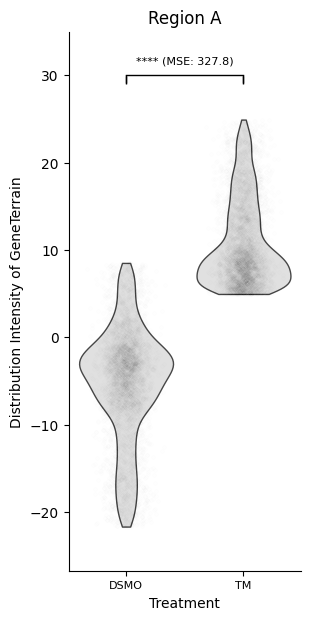

In [415]:
all_dht_data = intensity_24_TM_DMSO[1:]

veh_data=intensity_24_TM_DMSO[0]
p_values = [ttest_ind(dht_data, veh_data).pvalue for dht_data in all_dht_data]
# Calculate p-values for comparisons (using a simple t-test here for the example)

# Assuming all_dht_data is a list of arrays and veh_data is an array
mse_values = [mean_squared_error(dht_data, veh_data) for dht_data in all_dht_data]

# Set style to a neutral color for the plot
#plt.style.use('seaborn-whitegrid')

plt.style.use('default')
#plt.style.use('ggplot')

# Customize colors of the violin plots to neutral

neutral_color = '#D3D3D3'  # A common neutral color (light gray)

# Create a new figure with adjusted size
plt.figure(figsize=(3, 7))

# Create violin plots for each DHT group and the VEH group
positions = [1, 2]  # Positions on the x-axis
vp = plt.violinplot(all_dht_data + [veh_data], positions=positions, widths=0.8, showmeans=False, showmedians=False, showextrema=False)

# Customize colors of the violin plots to neutral
for pc in vp['bodies']:
    pc.set_facecolor(neutral_color)
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Adding scatter for the actual data points with smaller size
#scatter_positions = np.repeat(positions, [len(d) for d in all_dht_data] + [len(veh_data)])
scatter_data = np.concatenate(all_dht_data + [veh_data])
#plt.scatter(scatter_positions, scatter_data, color='black', alpha=0.2, s=1)
ax = plt.gca()

for i, data in enumerate(all_dht_data + [veh_data], 1):

    y = data

    x = np.random.normal(i, 0.1, size=len(y))

    ax.plot(x, y, 'k.', alpha=0.005)
# Remove top and right axis lines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adding the significance annotations for p-values and lines for more clarification
ymax = max(scatter_data) + 0.05
ymin = min(scatter_data) - 0.05
pval1=[]
for pval in p_values:
  if pval < 0.00001:
    pval = '****'
  elif pval < 0.0001:
    pval = '***'
  elif pval < 0.001:
    pval = '**'
  elif pval < 0.05:
    pval = '*'
  else:
     pval = 'ns'
  pval1.append(pval)
# Draw horizontal lines for each p-value annotation
for i, p_value in enumerate(pval1, 1):
    y_line = ymax + 5 + (1-i)*4  # increment y position for each line to avoid overlap
    plt.text((positions[i-1]+positions[-1])/2, round(y_line)+1, p_value+ ' (MSE: '+str(np.round(mse_values[i-1],1))+')', ha='center', va='bottom', fontsize=8)
    plt.plot([i, 2], [y_line, y_line], color="black", lw=1)
    plt.plot([i, i], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

    plt.plot([positions[-1], positions[-1]], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

# Set axis labels with a larger font size
plt.xticks(positions, ['DSMO','TM'], fontsize=8)
plt.ylabel('Distribution Intensity of GeneTerrain', fontsize=10)
plt.ylim(ymin-5, ymax + 10)  # Adjust the y-axis limit to accommodate annotation
plt.rcParams['figure.facecolor'] = 'white'
plt.xlabel('Treatment', fontsize=10)
plt.title("Region A")
plt.rcParams['axes.facecolor'] = 'white'
# Show the plot with the adjusted style
plt.show()

In [416]:
intensity_24=pd.DataFrame(intensity_24).T
intensity_24.columns=['DMSO_24','M_24','T_24','W_24','TM_24','TW_24','MW_24','TMW_24']

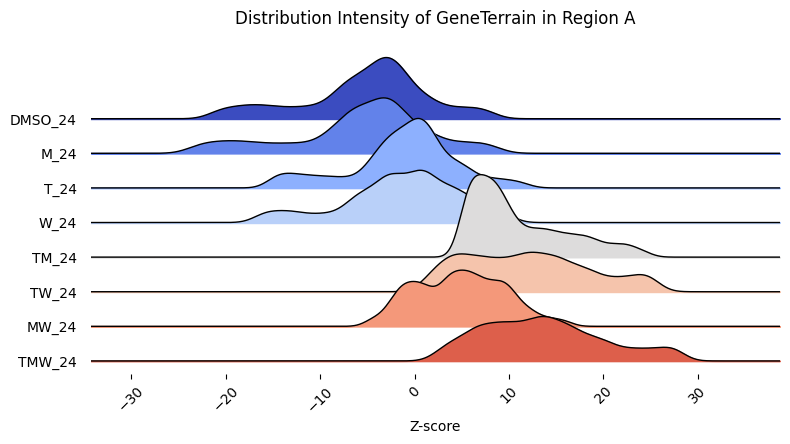

In [417]:
# Create the ridgeline plot
fig, axes = joyplot(
    intensity_24,
    colormap = cm.coolwarm,
    linewidth = 1,
    figsize=(8, 4),
    grid = False,
)

# Customize the plot
plt.xlabel("Z-score")
plt.ylabel("Treatment")

plt.title("Distribution Intensity of GeneTerrain in Region A")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

# **Plot of Different Treatments vs. Control in Region B**

In [418]:
intensity_24=[]
for i in range(5,len(outGT),6):
    print(outGT_name[i])
    mat = outGT[i, :]
    mat = mat.reshape(200, 200)
    #mat=(mat-np.min(mat))/(np.max(mat)-np.min(mat));
    #mat=2*mat-1
    intensity_24.append(mat[labels_im==2])

DMSO_24
M_24
T_24
W_24
TM_24
TW_24
MW_24
TMW_24


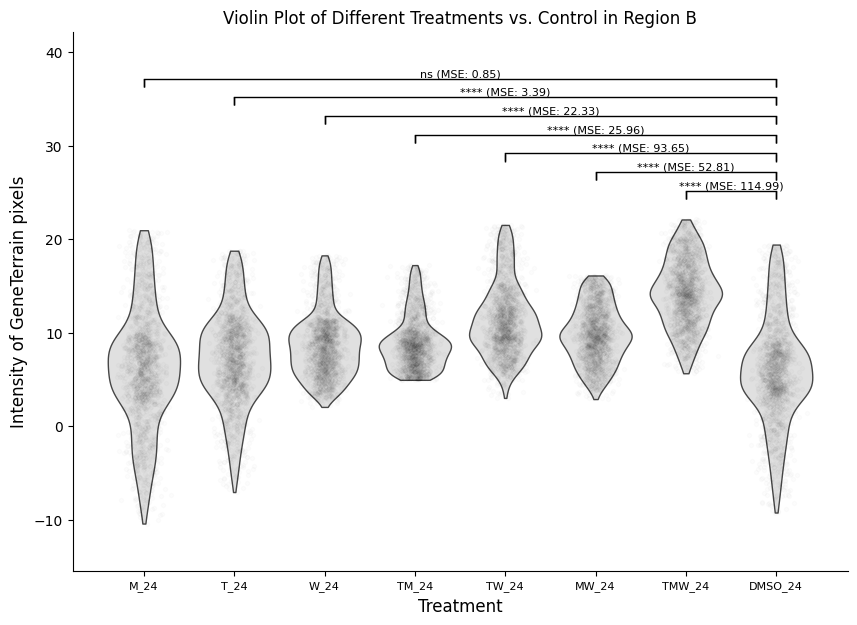

In [419]:
all_dht_data = intensity_24[1:]

veh_data=intensity_24[0]
p_values = [ttest_ind(dht_data, veh_data).pvalue for dht_data in all_dht_data]
# Calculate p-values for comparisons (using a simple t-test here for the example)

# Assuming all_dht_data is a list of arrays and veh_data is an array
mse_values = [mean_squared_error(dht_data, veh_data) for dht_data in all_dht_data]

# Set style to a neutral color for the plot
#plt.style.use('seaborn-whitegrid')

plt.style.use('default')
#plt.style.use('ggplot')

# Customize colors of the violin plots to neutral

neutral_color = '#D3D3D3'  # A common neutral color (light gray)

# Create a new figure with adjusted size
plt.figure(figsize=(10, 7))

# Create violin plots for each DHT group and the VEH group
positions = [1, 2, 3, 4, 5,6,7,8]  # Positions on the x-axis
vp = plt.violinplot(all_dht_data + [veh_data], positions=positions, widths=0.8, showmeans=False, showmedians=False, showextrema=False)

# Customize colors of the violin plots to neutral
for pc in vp['bodies']:
    pc.set_facecolor(neutral_color)
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Adding scatter for the actual data points with smaller size
#scatter_positions = np.repeat(positions, [len(d) for d in all_dht_data] + [len(veh_data)])
scatter_data = np.concatenate(all_dht_data + [veh_data])
#plt.scatter(scatter_positions, scatter_data, color='black', alpha=0.2, s=1)
ax = plt.gca()

for i, data in enumerate(all_dht_data + [veh_data], 1):

    y = data

    x = np.random.normal(i, 0.1, size=len(y))

    ax.plot(x, y, 'k.', alpha=0.01)
# Remove top and right axis lines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adding the significance annotations for p-values and lines for more clarification
ymax = max(scatter_data) + 0.05
ymin = min(scatter_data) - 0.05
pval1=[]
for pval in p_values:
  if pval < 0.00001:
    pval = '****'
  elif pval < 0.0001:
    pval = '***'
  elif pval < 0.001:
    pval = '**'
  elif pval < 0.05:
    pval = '*'
  else:
     pval = 'ns'
  pval1.append(pval)
# Draw horizontal lines for each p-value annotation
for i, p_value in enumerate(pval1, 1):
    y_line = ymax +15 + (1-i)*2  # increment y position for each line to avoid overlap
    plt.text((positions[i-1]+positions[-1])/2, y_line, p_value+ ' (MSE: '+str(np.round(mse_values[i-1],2))+')', ha='center', va='bottom', fontsize=8)
    plt.plot([i, 8], [y_line, y_line], color="black", lw=1)
    plt.plot([i, i], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

    plt.plot([positions[-1], positions[-1]], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

# Set axis labels with a larger font size
plt.xticks(positions, ['M_24','T_24','W_24','TM_24','TW_24', 'MW_24', 'TMW_24',  'DMSO_24'], fontsize=8)
plt.ylabel('Intensity of GeneTerrain pixels', fontsize=12)
plt.ylim(ymin-5, ymax +20)  # Adjust the y-axis limit to accommodate annotation
plt.rcParams['figure.facecolor'] = 'white'
plt.xlabel('Treatment', fontsize=12,)
plt.title("Violin Plot of Different Treatments vs. Control in Region B")
plt.rcParams['axes.facecolor'] = 'white'
# Show the plot with the adjusted style
plt.show()

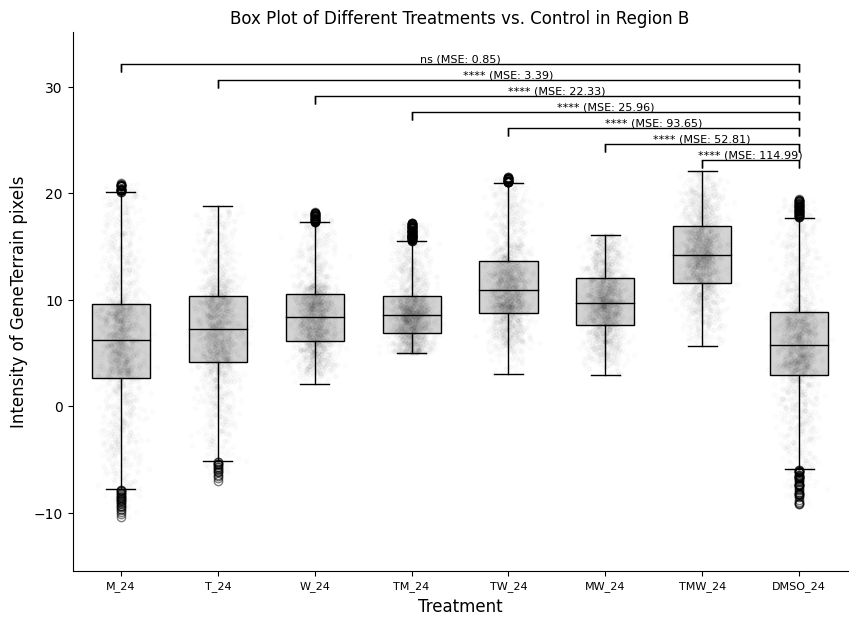

In [420]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem, ttest_ind
from sklearn.metrics import mean_squared_error

# Your data setup
all_dht_data = intensity_24[1:]
veh_data = intensity_24[0]
p_values = [ttest_ind(dht_data, veh_data).pvalue for dht_data in all_dht_data]
mse_values = [mean_squared_error(dht_data, veh_data) for dht_data in all_dht_data]

# Set style to default
plt.style.use('default')

# Create a new figure with adjusted size
plt.figure(figsize=(10, 7))

# Create box plots for each DHT group and the VEH group
positions = np.arange(1, len(all_dht_data) + 2)  # Positions on the x-axis

# Draw box plots and capture the returned dictionary
boxprops = dict(color="black", linestyle="-")
whiskerprops = dict(color="black", linestyle="-")
capprops = dict(color="black")
medianprops = dict(color="black", linestyle="-")
flierprops = dict(marker='o', color='black', alpha=0.5)

bp = plt.boxplot(all_dht_data + [veh_data], positions=positions, widths=0.6, patch_artist=True,
                 boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops, flierprops=flierprops)

# Change the face color of the boxes
for box in bp['boxes']:
    box.set(facecolor = '#D3D3D3')  # Light gray color
scatter_data = np.concatenate(all_dht_data + [veh_data])
#plt.scatter(scatter_positions, scatter_data, color='black', alpha=0.2, s=1)
ax = plt.gca()

for i, data in enumerate(all_dht_data + [veh_data], 1):

    y = data

    x = np.random.normal(i, 0.1, size=len(y))

    ax.plot(x, y, 'k.', alpha=0.01)

# Adding the significance annotations for p-values and lines for more clarification
ymax = max(scatter_data) + 0.05
ymin = min(scatter_data) - 0.05
pval1=[]
for pval in p_values:
  if pval < 0.00001:
    pval = '****'
  elif pval > 0.00001 and pval< 0.0001:
    pval = '***'
  elif pval > 0.0001 and pval< 0.001:
    pval = '**'
  elif pval > 0.001 and pval < 0.05:
    pval = '*'
  elif pval > 0.05:
    pval = 'ns'
  #else:
     #pval = 'ns'
  pval1.append(pval)
# Draw horizontal lines for each p-value annotation
for i, p_value in enumerate(pval1, 1):
    y_line = ymax + 10 + (1-i)*1.5  # increment y position for each line to avoid overlap
    plt.text((positions[i-1]+positions[-1])/2, y_line, p_value+ ' (MSE: '+str(np.round(mse_values[i-1],2))+')', ha='center', va='bottom', fontsize=8)
    plt.plot([i, 8], [y_line, y_line], color="black", lw=1)
    plt.plot([i, i], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

    plt.plot([positions[-1], positions[-1]], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

# Additional plot adjustments
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set axis labels with a larger font size
plt.xticks(positions, ['M_24','T_24','W_24','TM_24','TW_24', 'MW_24', 'TMW_24',  'DMSO_24'], fontsize=8)
plt.ylabel('Intensity of GeneTerrain pixels', fontsize=12)
plt.ylim(ymin-5, ymax +13)  # Adjust the y-axis limit to accommodate annotation
plt.rcParams['figure.facecolor'] = 'white'
plt.xlabel('Treatment', fontsize=12,)
plt.title("Box Plot of Different Treatments vs. Control in Region B")
plt.rcParams['axes.facecolor'] = 'white'
# Show the plot with the adjusted style
plt.show()

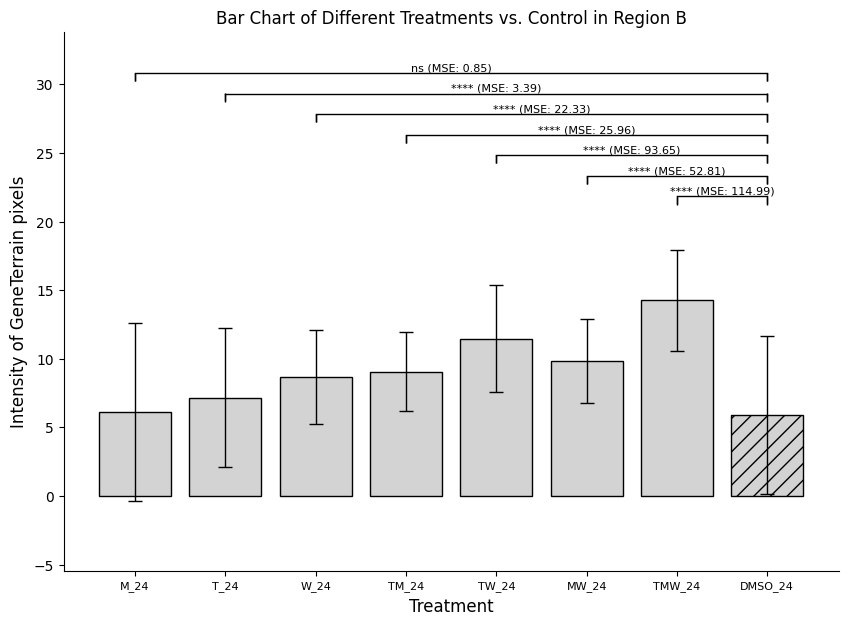

In [421]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'all_dht_data' and 'veh_data' are defined earlier in your code
# and 'positions', 'neutral_color', 'pval1', 'mse_values', 'ymin' are also predefined

# Generating mean and standard deviation for each group for the bar chart
mean_dht_data = [np.mean(dht) for dht in all_dht_data]
std_dht_data = [np.std(dht, ddof=1) for dht in all_dht_data]  # Using sample standard deviation
mean_veh_data = np.mean(veh_data)
std_veh_data = np.std(veh_data, ddof=1)  # Using sample standard deviation

# Set the background to white
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Create a new figure with adjusted size
plt.figure(figsize=(10, 7))

# Adjusting positions to match the number of DHT groups plus the VEH group
# Assuming 'positions' is a list of positions for each group
bar_positions_dht = positions[:-1]  # Use all but the last position for DHT groups
bar_positions_veh = positions[-1]  # Use the last position for the VEH group

# Plot bars for DHT groups
plt.bar(bar_positions_dht, mean_dht_data, yerr=std_dht_data, color=neutral_color, capsize=5, edgecolor='black', error_kw=dict(elinewidth=1, ecolor='black'))

# Plot bar for VEH group as a single bar, turning mean and std into lists to match the expected format
plt.bar([bar_positions_veh], [mean_veh_data], yerr=[std_veh_data], color=neutral_color, capsize=5, edgecolor='black', hatch="//", error_kw=dict(elinewidth=1, ecolor='black'))
# Adding the significance annotations for p-values
ymax = max(mean_dht_data + [mean_veh_data]) + max(std_dht_data + [std_veh_data]) + 0.1

# Draw horizontal lines for each p-value annotation
for i, p_value in enumerate(pval1, 1):
    y_line = ymax + 10 + (1-i)*1.5  # increment y position for each line to avoid overlap
    plt.text((positions[i-1]+positions[-1])/2, y_line+.01, p_value+ ' (MSE: '+str(np.round(mse_values[i-1],2))+')', ha='center', va='bottom', fontsize=8)
    plt.plot([i, 8], [y_line, y_line], color="black", lw=1)
    plt.plot([i, i], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

    plt.plot([positions[-1], positions[-1]], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

# Additional plot adjustments
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set axis labels with a larger font size
plt.xticks(positions, ['M_24','T_24','W_24','TM_24','TW_24', 'MW_24', 'TMW_24',  'DMSO_24'], fontsize=8)
plt.ylabel('Intensity of GeneTerrain pixels', fontsize=12)
plt.ylim(ymin+5, ymax +13)  # Adjust the y-axis limit to accommodate annotation
plt.rcParams['figure.facecolor'] = 'white'
plt.xlabel('Treatment', fontsize=12,)
plt.title("Bar Chart of Different Treatments vs. Control in Region B")
plt.rcParams['axes.facecolor'] = 'white'
# Show the plot with the adjusted style
plt.show()


In [422]:
intensity_24_TM_DMSO=[]

mat = outGT[29, :]
mat = mat.reshape(200, 200)
intensity_24_TM_DMSO.append(mat[labels_im==2])
mat = outGT[5, :]
mat = mat.reshape(200, 200)
intensity_24_TM_DMSO.append(mat[labels_im==2])

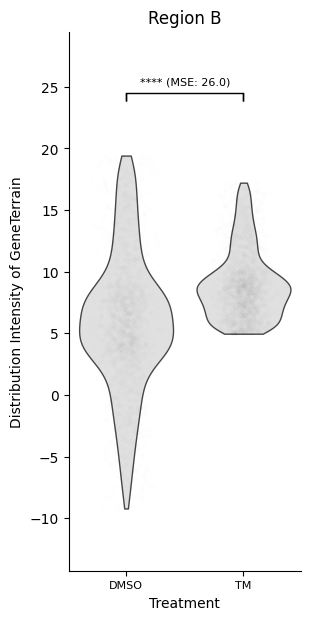

In [423]:
all_dht_data = intensity_24_TM_DMSO[1:]

veh_data=intensity_24_TM_DMSO[0]
p_values = [ttest_ind(dht_data, veh_data).pvalue for dht_data in all_dht_data]
# Calculate p-values for comparisons (using a simple t-test here for the example)

# Assuming all_dht_data is a list of arrays and veh_data is an array
mse_values = [mean_squared_error(dht_data, veh_data) for dht_data in all_dht_data]

# Set style to a neutral color for the plot
#plt.style.use('seaborn-whitegrid')

plt.style.use('default')
#plt.style.use('ggplot')

# Customize colors of the violin plots to neutral

neutral_color = '#D3D3D3'  # A common neutral color (light gray)

# Create a new figure with adjusted size
plt.figure(figsize=(3, 7))

# Create violin plots for each DHT group and the VEH group
positions = [1, 2]  # Positions on the x-axis
vp = plt.violinplot(all_dht_data + [veh_data], positions=positions, widths=0.8, showmeans=False, showmedians=False, showextrema=False)

# Customize colors of the violin plots to neutral
for pc in vp['bodies']:
    pc.set_facecolor(neutral_color)
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Adding scatter for the actual data points with smaller size
#scatter_positions = np.repeat(positions, [len(d) for d in all_dht_data] + [len(veh_data)])
scatter_data = np.concatenate(all_dht_data + [veh_data])
#plt.scatter(scatter_positions, scatter_data, color='black', alpha=0.2, s=1)
ax = plt.gca()

for i, data in enumerate(all_dht_data + [veh_data], 1):

    y = data

    x = np.random.normal(i, 0.1, size=len(y))

    ax.plot(x, y, 'k.', alpha=0.005)
# Remove top and right axis lines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adding the significance annotations for p-values and lines for more clarification
ymax = max(scatter_data) + 0.05
ymin = min(scatter_data) - 0.05
pval1=[]
for pval in p_values:
  if pval < 0.00001:
    pval = '****'
  elif pval < 0.0001:
    pval = '***'
  elif pval < 0.001:
    pval = '**'
  elif pval < 0.05:
    pval = '*'
  else:
     pval = 'ns'
  pval1.append(pval)
# Draw horizontal lines for each p-value annotation
for i, p_value in enumerate(pval1, 1):
    y_line = ymax + 5 + (1-i)*4  # increment y position for each line to avoid overlap
    plt.text((positions[i-1]+positions[-1])/2, round(y_line)+1, p_value+ ' (MSE: '+str(np.round(mse_values[i-1],1))+')', ha='center', va='bottom', fontsize=8)
    plt.plot([i, 2], [y_line, y_line], color="black", lw=1)
    plt.plot([i, i], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

    plt.plot([positions[-1], positions[-1]], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

# Set axis labels with a larger font size
plt.xticks(positions, ['DMSO','TM'], fontsize=8)
plt.ylabel('Distribution Intensity of GeneTerrain', fontsize=10)
plt.ylim(ymin-5, ymax + 10)  # Adjust the y-axis limit to accommodate annotation
plt.rcParams['figure.facecolor'] = 'white'
plt.xlabel('Treatment', fontsize=10)
plt.title("Region B")
plt.rcParams['axes.facecolor'] = 'white'
# Show the plot with the adjusted style
plt.show()

In [424]:
intensity_24=pd.DataFrame(intensity_24).T
intensity_24.columns=['DMSO_24','M_24','T_24','W_24','TM_24','TW_24','MW_24','TMW_24']

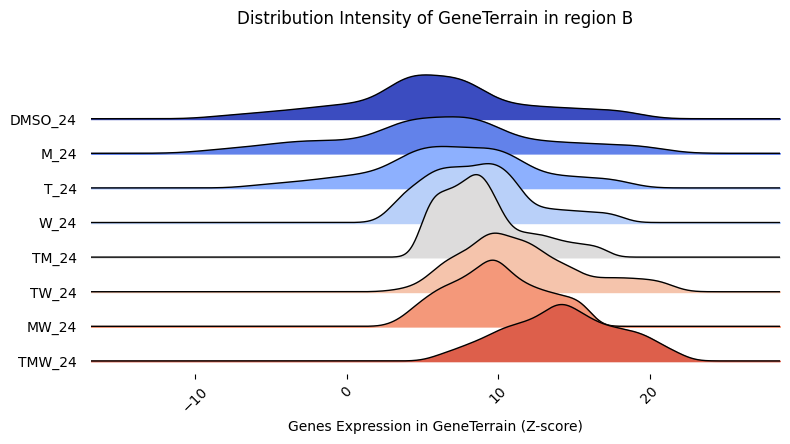

In [425]:
# Create the ridgeline plot
fig, axes = joyplot(
    intensity_24,
    colormap = cm.coolwarm,
    linewidth = 1,
    figsize=(8, 4),
    grid = False,


)

# Customize the plot
plt.xlabel("Genes Expression in GeneTerrain (Z-score)")
plt.ylabel("Treatment")
plt.title("Distribution Intensity of GeneTerrain in region B")



# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


# **Plot of Different Treatments vs. Control in Region C**

In [426]:
intensity_24=[]
for i in range(5,len(outGT),6):
    print(outGT_name[i])
    mat = outGT[i, :]
    mat = mat.reshape(200, 200)
    #mat=(mat-np.min(mat))/(np.max(mat)-np.min(mat));
    #mat=2*mat-1
    intensity_24.append(mat[labels_im==4])

DMSO_24
M_24
T_24
W_24
TM_24
TW_24
MW_24
TMW_24


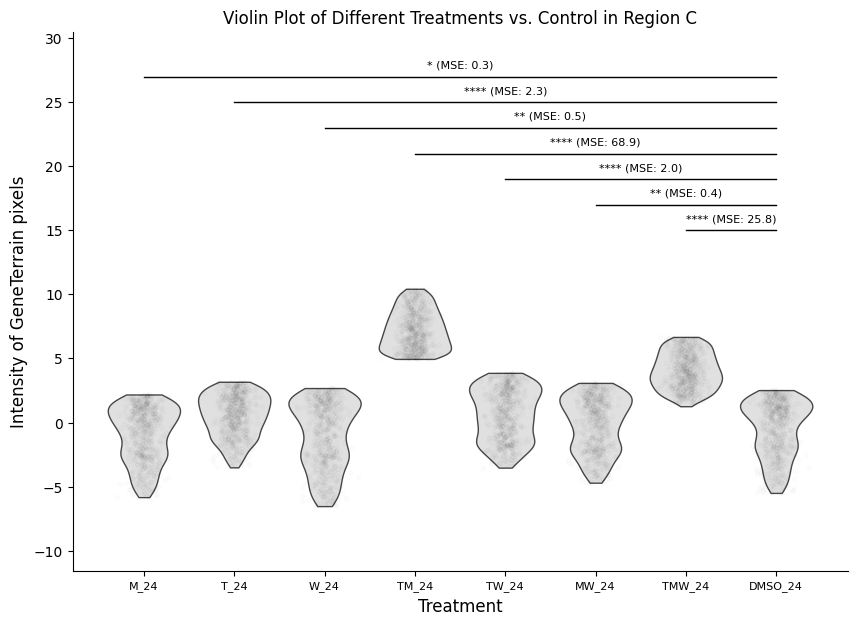

In [427]:
all_dht_data = intensity_24[1:]

veh_data=intensity_24[0]
p_values = [ttest_ind(dht_data, veh_data).pvalue for dht_data in all_dht_data]
# Calculate p-values for comparisons (using a simple t-test here for the example)

# Assuming all_dht_data is a list of arrays and veh_data is an array
mse_values = [mean_squared_error(dht_data, veh_data) for dht_data in all_dht_data]

# Set style to a neutral color for the plot
#plt.style.use('seaborn-whitegrid')

plt.style.use('default')
#plt.style.use('ggplot')

# Customize colors of the violin plots to neutral

neutral_color = '#D3D3D3'  # A common neutral color (light gray)

# Create a new figure with adjusted size
plt.figure(figsize=(10, 7))

# Create violin plots for each DHT group and the VEH group
positions = [1, 2, 3, 4, 5,6,7,8]  # Positions on the x-axis
vp = plt.violinplot(all_dht_data + [veh_data], positions=positions, widths=0.8, showmeans=False, showmedians=False, showextrema=False)

# Customize colors of the violin plots to neutral
for pc in vp['bodies']:
    pc.set_facecolor(neutral_color)
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Adding scatter for the actual data points with smaller size
#scatter_positions = np.repeat(positions, [len(d) for d in all_dht_data] + [len(veh_data)])
scatter_data = np.concatenate(all_dht_data + [veh_data])
#plt.scatter(scatter_positions, scatter_data, color='black', alpha=0.2, s=1)
ax = plt.gca()

for i, data in enumerate(all_dht_data + [veh_data], 1):

    y = data

    x = np.random.normal(i, 0.1, size=len(y))

    ax.plot(x, y, 'k.', alpha=0.01)
# Remove top and right axis lines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adding the significance annotations for p-values and lines for more clarification
ymax = max(scatter_data) + 0.05
ymin = min(scatter_data) - 0.05
pval1=[]
for pval in p_values:
  if pval < 0.00001:
    pval = '****'
  elif pval < 0.0001:
    pval = '***'
  elif pval < 0.001:
    pval = '**'
  elif pval < 0.05:
    pval = '*'
  else:
     pval = 'ns'
  pval1.append(pval)
# Draw horizontal lines for each p-value annotation
for i, p_value in enumerate(pval1, 1):
    y_line = ymax + 16.5 + (1-i)*2  # increment y position for each line to avoid overlap
    plt.text((positions[i-1]+positions[-1])/2, round(y_line)+.5, p_value+ ' (MSE: '+str(np.round(mse_values[i-1],1))+')', ha='center', va='bottom', fontsize=8)
    plt.plot([i, 8], [y_line, y_line], color="black", lw=1)
    #plt.plot([i, i], [y_line - 0.01, y_line + 0.01], color="black", lw=1, marker='|')


    #plt.plot([positions[-1], positions[-1]], [y_line - 0.01, y_line + 0.01], color="black", lw=1, marker='|')

# Set axis labels with a larger font size
plt.xticks(positions, ['M_24','T_24','W_24','TM_24','TW_24', 'MW_24', 'TMW_24',  'DMSO_24'], fontsize=8)
plt.ylabel('Intensity of GeneTerrain pixels', fontsize=12)
plt.ylim(ymin-5, ymax + 20)  # Adjust the y-axis limit to accommodate annotation
plt.rcParams['figure.facecolor'] = 'white'
plt.xlabel('Treatment', fontsize=12,)
plt.title("Violin Plot of Different Treatments vs. Control in Region C")
plt.rcParams['axes.facecolor'] = 'white'
# Show the plot with the adjusted style
plt.show()

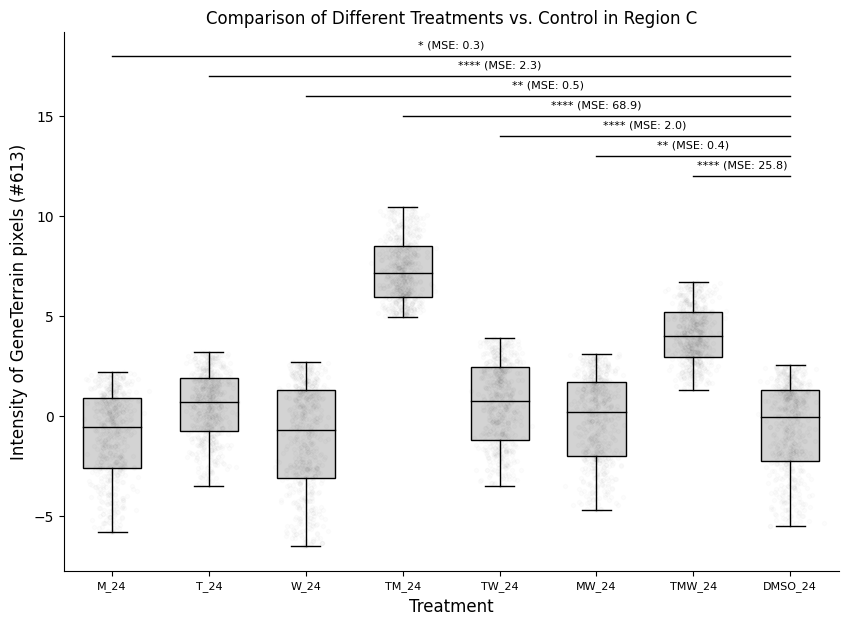

In [428]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem, ttest_ind
from sklearn.metrics import mean_squared_error

# Your data setup
all_dht_data = intensity_24[1:]
veh_data = intensity_24[0]
p_values = [ttest_ind(dht_data, veh_data).pvalue for dht_data in all_dht_data]
mse_values = [mean_squared_error(dht_data, veh_data) for dht_data in all_dht_data]

# Set style to default
plt.style.use('default')

# Create a new figure with adjusted size
plt.figure(figsize=(10, 7))

# Create box plots for each DHT group and the VEH group
positions = np.arange(1, len(all_dht_data) + 2)  # Positions on the x-axis

# Draw box plots and capture the returned dictionary
boxprops = dict(color="black", linestyle="-")
whiskerprops = dict(color="black", linestyle="-")
capprops = dict(color="black")
medianprops = dict(color="black", linestyle="-")
flierprops = dict(marker='o', color='black', alpha=0.5)

bp = plt.boxplot(all_dht_data + [veh_data], positions=positions, widths=0.6, patch_artist=True,
                 boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops, flierprops=flierprops)

# Change the face color of the boxes
for box in bp['boxes']:
    box.set(facecolor = '#D3D3D3')  # Light gray color
scatter_data = np.concatenate(all_dht_data + [veh_data])
#plt.scatter(scatter_positions, scatter_data, color='black', alpha=0.2, s=1)
ax = plt.gca()

for i, data in enumerate(all_dht_data + [veh_data], 1):

    y = data

    x = np.random.normal(i, 0.1, size=len(y))

    ax.plot(x, y, 'k.', alpha=0.01)

# Adding the significance annotations for p-values and lines for more clarification
ymax = max(scatter_data) + 0.05
ymin = min(scatter_data) - 0.05
pval1=[]
for pval in p_values:
  if pval < 0.00001:
    pval = '****'
  elif pval > 0.00001 and pval< 0.0001:
    pval = '***'
  elif pval > 0.0001 and pval< 0.001:
    pval = '**'
  elif pval > 0.001 and pval < 0.05:
    pval = '*'
  elif pval > 0.05:
    pval = 'ns'
  #else:
     #pval = 'ns'
  pval1.append(pval)
# Draw horizontal lines for each p-value annotation
for i, p_value in enumerate(pval1, 1):
    y_line = ymax + 7.5 + (1-i)*1  # increment y position for each line to avoid overlap
    plt.text((positions[i-1]+positions[-1])/2, round(y_line)+.3, p_value+ ' (MSE: '+str(np.round(mse_values[i-1],1))+')', ha='center', va='bottom', fontsize=8)
    plt.plot([i, 8], [y_line, y_line], color="black", lw=1)


# Additional plot adjustments
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(positions, ['M_24', 'T_24', 'W_24', 'TM_24', 'TW_24', 'MW_24', 'TMW_24', 'DMSO_24'], fontsize=8)
plt.ylabel('Intensity of GeneTerrain pixels (#'+ str(len(veh_data))+')', fontsize=12)
plt.xlabel('Treatment', fontsize=12)
plt.title("Comparison of Different Treatments vs. Control in Region C")
plt.show()

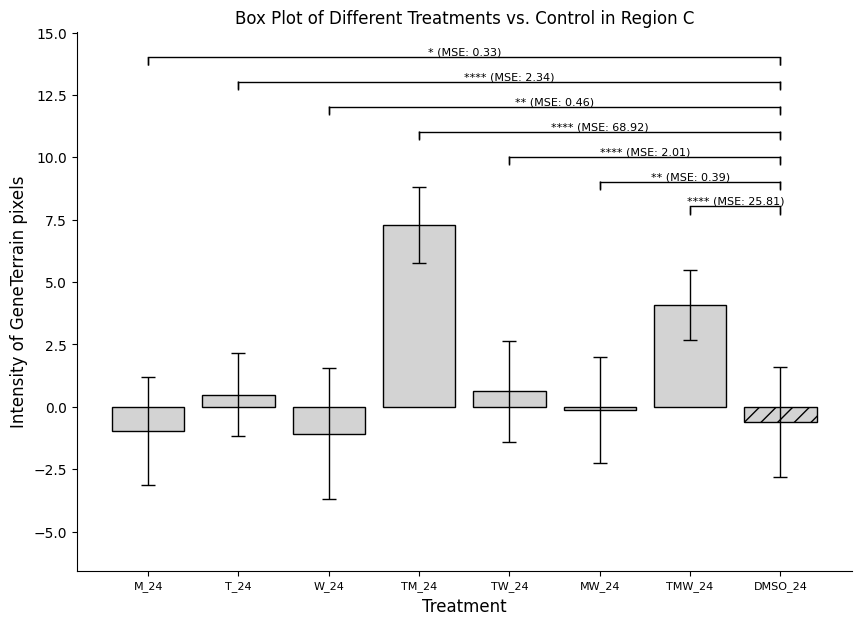

In [429]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'all_dht_data' and 'veh_data' are defined earlier in your code
# and 'positions', 'neutral_color', 'pval1', 'mse_values', 'ymin' are also predefined

# Generating mean and standard deviation for each group for the bar chart
mean_dht_data = [np.mean(dht) for dht in all_dht_data]
std_dht_data = [np.std(dht, ddof=1) for dht in all_dht_data]  # Using sample standard deviation
mean_veh_data = np.mean(veh_data)
std_veh_data = np.std(veh_data, ddof=1)  # Using sample standard deviation

# Set the background to white
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Create a new figure with adjusted size
plt.figure(figsize=(10, 7))

# Adjusting positions to match the number of DHT groups plus the VEH group
# Assuming 'positions' is a list of positions for each group
bar_positions_dht = positions[:-1]  # Use all but the last position for DHT groups
bar_positions_veh = positions[-1]  # Use the last position for the VEH group

# Plot bars for DHT groups
plt.bar(bar_positions_dht, mean_dht_data, yerr=std_dht_data, color=neutral_color, capsize=5, edgecolor='black', error_kw=dict(elinewidth=1, ecolor='black'))

# Plot bar for VEH group as a single bar, turning mean and std into lists to match the expected format
plt.bar([bar_positions_veh], [mean_veh_data], yerr=[std_veh_data], color=neutral_color, capsize=5, edgecolor='black', hatch="//", error_kw=dict(elinewidth=1, ecolor='black'))
# Adding the significance annotations for p-values
ymax = max(mean_dht_data + [mean_veh_data]) + max(std_dht_data + [std_veh_data]) + 0.1

# Draw horizontal lines for each p-value annotation
for i, p_value in enumerate(pval1, 1):
    y_line = ymax + 4 + (1-i)*1  # increment y position for each line to avoid overlap
    plt.text((positions[i-1]+positions[-1])/2, y_line, p_value+ ' (MSE: '+str(np.round(mse_values[i-1],2))+')', ha='center', va='bottom', fontsize=8)
    plt.plot([i, 8], [y_line, y_line], color="black", lw=1)
    plt.plot([i, i], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

    plt.plot([positions[-1], positions[-1]], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

# Additional plot adjustments
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set axis labels with a larger font size
plt.xticks(positions, ['M_24','T_24','W_24','TM_24','TW_24', 'MW_24', 'TMW_24',  'DMSO_24'], fontsize=8)
plt.ylabel('Intensity of GeneTerrain pixels', fontsize=12)
plt.ylim(ymin, ymax +5)  # Adjust the y-axis limit to accommodate annotation
plt.rcParams['figure.facecolor'] = 'white'
plt.xlabel('Treatment', fontsize=12,)
plt.title("Box Plot of Different Treatments vs. Control in Region C")
plt.rcParams['axes.facecolor'] = 'white'
# Show the plot with the adjusted style
plt.show()


In [430]:
intensity_24_TM_DMSO=[]

mat = outGT[29, :]
mat = mat.reshape(200, 200)
intensity_24_TM_DMSO.append(mat[labels_im==4])
mat = outGT[5, :]
mat = mat.reshape(200, 200)
intensity_24_TM_DMSO.append(mat[labels_im==4])

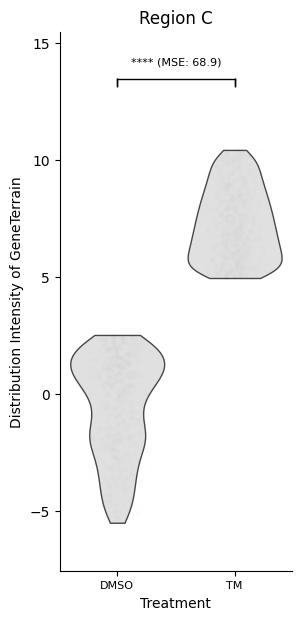

In [431]:
all_dht_data = intensity_24_TM_DMSO[1:]

veh_data=intensity_24_TM_DMSO[0]
p_values = [ttest_ind(dht_data, veh_data).pvalue for dht_data in all_dht_data]
# Calculate p-values for comparisons (using a simple t-test here for the example)

# Assuming all_dht_data is a list of arrays and veh_data is an array
mse_values = [mean_squared_error(dht_data, veh_data) for dht_data in all_dht_data]

# Set style to a neutral color for the plot
#plt.style.use('seaborn-whitegrid')

plt.style.use('default')
#plt.style.use('ggplot')

# Customize colors of the violin plots to neutral

neutral_color = '#D3D3D3'  # A common neutral color (light gray)

# Create a new figure with adjusted size
plt.figure(figsize=(3, 7))

# Create violin plots for each DHT group and the VEH group
positions = [1, 2]  # Positions on the x-axis
vp = plt.violinplot(all_dht_data + [veh_data], positions=positions, widths=0.8, showmeans=False, showmedians=False, showextrema=False)

# Customize colors of the violin plots to neutral
for pc in vp['bodies']:
    pc.set_facecolor(neutral_color)
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Adding scatter for the actual data points with smaller size
#scatter_positions = np.repeat(positions, [len(d) for d in all_dht_data] + [len(veh_data)])
scatter_data = np.concatenate(all_dht_data + [veh_data])
#plt.scatter(scatter_positions, scatter_data, color='black', alpha=0.2, s=1)
ax = plt.gca()

for i, data in enumerate(all_dht_data + [veh_data], 1):

    y = data

    x = np.random.normal(i, 0.1, size=len(y))

    ax.plot(x, y, 'k.', alpha=0.005)
# Remove top and right axis lines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adding the significance annotations for p-values and lines for more clarification
ymax = max(scatter_data) + 0.05
ymin = min(scatter_data) - 0.05
pval1=[]
for pval in p_values:
  if pval < 0.00001:
    pval = '****'
  elif pval < 0.0001:
    pval = '***'
  elif pval < 0.001:
    pval = '**'
  elif pval < 0.05:
    pval = '*'
  else:
     pval = 'ns'
  pval1.append(pval)
# Draw horizontal lines for each p-value annotation
for i, p_value in enumerate(pval1, 1):
    y_line = ymax + 3+ (1-i)*4  # increment y position for each line to avoid overlap
    plt.text((positions[i-1]+positions[-1])/2, round(y_line)+1, p_value+ ' (MSE: '+str(np.round(mse_values[i-1],1))+')', ha='center', va='bottom', fontsize=8)
    plt.plot([i, 2], [y_line, y_line], color="black", lw=1)
    plt.plot([i, i], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

    plt.plot([positions[-1], positions[-1]], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

# Set axis labels with a larger font size
plt.xticks(positions, ['DMSO','TM'], fontsize=8)
plt.ylabel('Distribution Intensity of GeneTerrain', fontsize=10)
plt.ylim(ymin-2, ymax + 5)  # Adjust the y-axis limit to accommodate annotation
plt.rcParams['figure.facecolor'] = 'white'
plt.xlabel('Treatment', fontsize=10)
plt.title("Region C")
plt.rcParams['axes.facecolor'] = 'white'
# Show the plot with the adjusted style
plt.show()

In [432]:
intensity_24=pd.DataFrame(intensity_24).T
intensity_24.columns=['DMSO_24','M_24','T_24','W_24','TM_24','TW_24','MW_24','TMW_24']

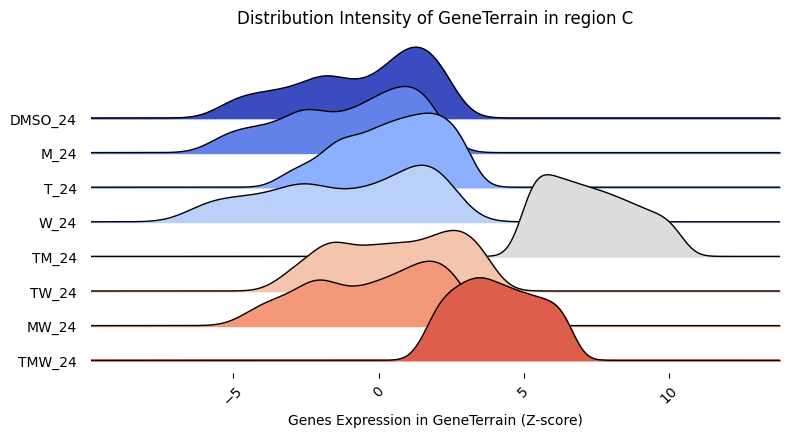

In [433]:
# Create the ridgeline plot
fig, axes = joyplot(
    intensity_24,
    colormap = cm.coolwarm,
    linewidth = 1,
    figsize=(8, 4),
    grid = False,


)

# Customize the plot
plt.xlabel("Genes Expression in GeneTerrain (Z-score)")
plt.ylabel("Treatment")
plt.title("Distribution Intensity of GeneTerrain in region C")



# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

# **Plot of Different Treatments vs. Control in Region D**

In [434]:
intensity_24=[]
for i in range(5,len(outGT),6):
    print(outGT_name[i])
    mat = outGT[i, :]
    mat = mat.reshape(200, 200)
    #mat=(mat-np.min(mat))/(np.max(mat)-np.min(mat));
    #mat=2*mat-1
    intensity_24.append(mat[labels_im==1])

DMSO_24
M_24
T_24
W_24
TM_24
TW_24
MW_24
TMW_24


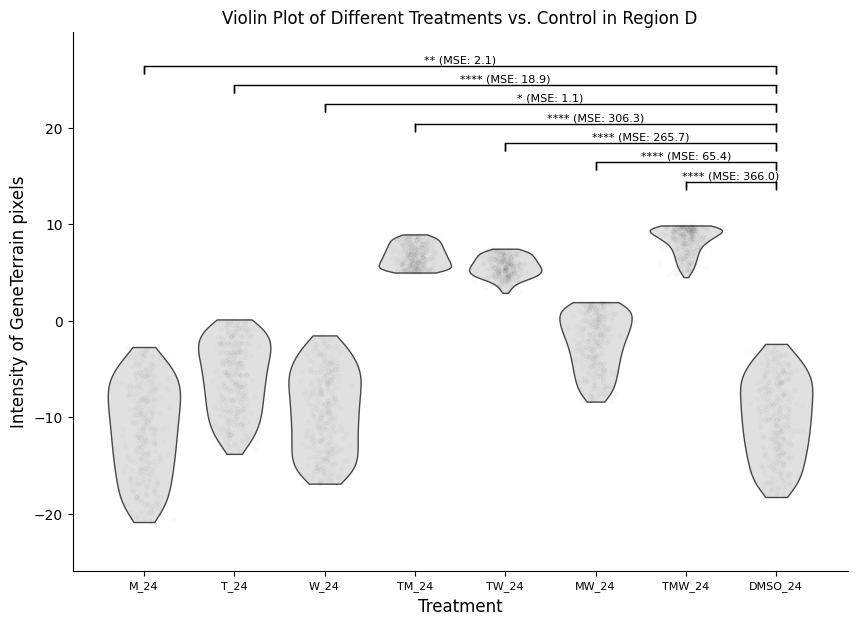

In [435]:
all_dht_data = intensity_24[1:]

veh_data=intensity_24[0]
p_values = [ttest_ind(dht_data, veh_data).pvalue for dht_data in all_dht_data]
# Calculate p-values for comparisons (using a simple t-test here for the example)

# Assuming all_dht_data is a list of arrays and veh_data is an array
mse_values = [mean_squared_error(dht_data, veh_data) for dht_data in all_dht_data]

# Set style to a neutral color for the plot
#plt.style.use('seaborn-whitegrid')

plt.style.use('default')
#plt.style.use('ggplot')

# Customize colors of the violin plots to neutral

neutral_color = '#D3D3D3'  # A common neutral color (light gray)

# Create a new figure with adjusted size
plt.figure(figsize=(10, 7))

# Create violin plots for each DHT group and the VEH group
positions = [1, 2, 3, 4, 5,6,7,8]  # Positions on the x-axis
vp = plt.violinplot(all_dht_data + [veh_data], positions=positions, widths=0.8, showmeans=False, showmedians=False, showextrema=False)

# Customize colors of the violin plots to neutral
for pc in vp['bodies']:
    pc.set_facecolor(neutral_color)
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Adding scatter for the actual data points with smaller size
#scatter_positions = np.repeat(positions, [len(d) for d in all_dht_data] + [len(veh_data)])
scatter_data = np.concatenate(all_dht_data + [veh_data])
#plt.scatter(scatter_positions, scatter_data, color='black', alpha=0.2, s=1)
ax = plt.gca()

for i, data in enumerate(all_dht_data + [veh_data], 1):

    y = data

    x = np.random.normal(i, 0.1, size=len(y))

    ax.plot(x, y, 'k.', alpha=0.01)
# Remove top and right axis lines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adding the significance annotations for p-values and lines for more clarification
ymax = max(scatter_data) + 0.05
ymin = min(scatter_data) - 0.05
pval1=[]
for pval in p_values:
  if pval < 0.00001:
    pval = '****'
  elif pval < 0.0001:
    pval = '***'
  elif pval < 0.001:
    pval = '**'
  elif pval < 0.05:
    pval = '*'
  else:
     pval = 'ns'
  pval1.append(pval)
# Draw horizontal lines for each p-value annotation
for i, p_value in enumerate(pval1, 1):
    y_line = ymax + 16.5 + (1-i)*2  # increment y position for each line to avoid overlap
    plt.text((positions[i-1]+positions[-1])/2, round(y_line)+.5, p_value+ ' (MSE: '+str(np.round(mse_values[i-1],1))+')', ha='center', va='bottom', fontsize=8)
    plt.plot([i, 8], [y_line, y_line], color="black", lw=1)
    plt.plot([i, i], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

    plt.plot([positions[-1], positions[-1]], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

# Set axis labels with a larger font size
plt.xticks(positions, ['M_24','T_24','W_24','TM_24','TW_24', 'MW_24', 'TMW_24',  'DMSO_24'], fontsize=8)
plt.ylabel('Intensity of GeneTerrain pixels', fontsize=12)
plt.ylim(ymin-5, ymax + 20)  # Adjust the y-axis limit to accommodate annotation
plt.rcParams['figure.facecolor'] = 'white'
plt.xlabel('Treatment', fontsize=12,)
plt.title("Violin Plot of Different Treatments vs. Control in Region D")
plt.rcParams['axes.facecolor'] = 'white'
# Show the plot with the adjusted style
plt.show()

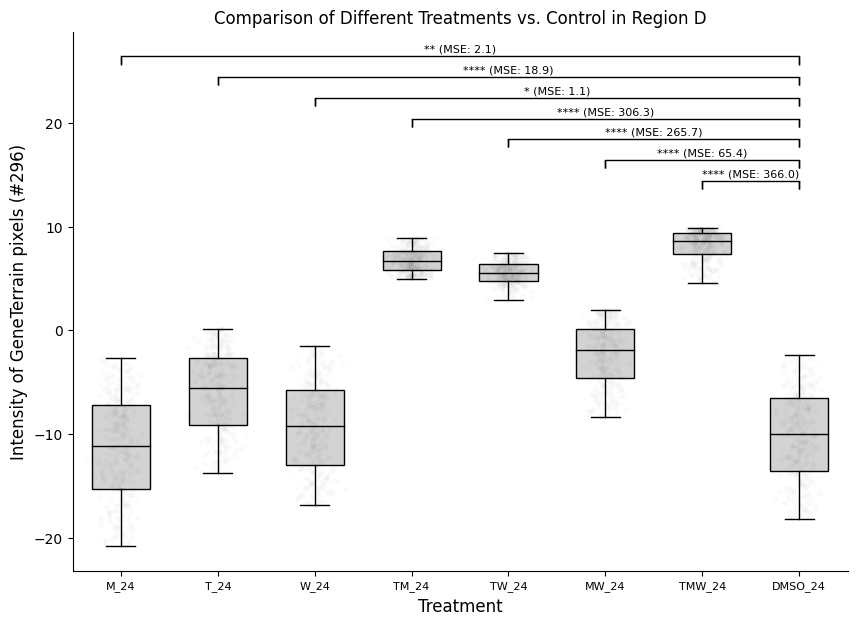

In [436]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem, ttest_ind
from sklearn.metrics import mean_squared_error

# Your data setup
all_dht_data = intensity_24[1:]
veh_data = intensity_24[0]
p_values = [ttest_ind(dht_data, veh_data).pvalue for dht_data in all_dht_data]
mse_values = [mean_squared_error(dht_data, veh_data) for dht_data in all_dht_data]

# Set style to default
plt.style.use('default')

# Create a new figure with adjusted size
plt.figure(figsize=(10, 7))

# Create box plots for each DHT group and the VEH group
positions = np.arange(1, len(all_dht_data) + 2)  # Positions on the x-axis

# Draw box plots and capture the returned dictionary
boxprops = dict(color="black", linestyle="-")
whiskerprops = dict(color="black", linestyle="-")
capprops = dict(color="black")
medianprops = dict(color="black", linestyle="-")
flierprops = dict(marker='o', color='black', alpha=0.5)

bp = plt.boxplot(all_dht_data + [veh_data], positions=positions, widths=0.6, patch_artist=True,
                 boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops, flierprops=flierprops)

# Change the face color of the boxes
for box in bp['boxes']:
    box.set(facecolor = '#D3D3D3')  # Light gray color
scatter_data = np.concatenate(all_dht_data + [veh_data])
#plt.scatter(scatter_positions, scatter_data, color='black', alpha=0.2, s=1)
ax = plt.gca()

for i, data in enumerate(all_dht_data + [veh_data], 1):

    y = data

    x = np.random.normal(i, 0.1, size=len(y))

    ax.plot(x, y, 'k.', alpha=0.01)

# Adding the significance annotations for p-values and lines for more clarification
ymax = max(scatter_data) + 0.05
ymin = min(scatter_data) - 0.05
pval1=[]
for pval in p_values:
  if pval < 0.00001:
    pval = '****'
  elif pval > 0.00001 and pval< 0.0001:
    pval = '***'
  elif pval > 0.0001 and pval< 0.001:
    pval = '**'
  elif pval > 0.001 and pval < 0.05:
    pval = '*'
  elif pval > 0.05:
    pval = 'ns'
  #else:
     #pval = 'ns'
  pval1.append(pval)
# Draw horizontal lines for each p-value annotation
for i, p_value in enumerate(pval1, 1):
    y_line = ymax + 16.5 + (1-i)*2  # increment y position for each line to avoid overlap
    plt.text((positions[i-1]+positions[-1])/2, round(y_line)+.6, p_value+ ' (MSE: '+str(np.round(mse_values[i-1],1))+')', ha='center', va='bottom', fontsize=8)
    plt.plot([i, 8], [y_line, y_line], color="black", lw=1)
    plt.plot([i, i], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

    plt.plot([positions[-1], positions[-1]], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

# Additional plot adjustments
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(positions, ['M_24', 'T_24', 'W_24', 'TM_24', 'TW_24', 'MW_24', 'TMW_24', 'DMSO_24'], fontsize=8)
plt.ylabel('Intensity of GeneTerrain pixels (#'+ str(len(veh_data))+')', fontsize=12)
plt.xlabel('Treatment', fontsize=12)
plt.title("Comparison of Different Treatments vs. Control in Region D")
plt.show()

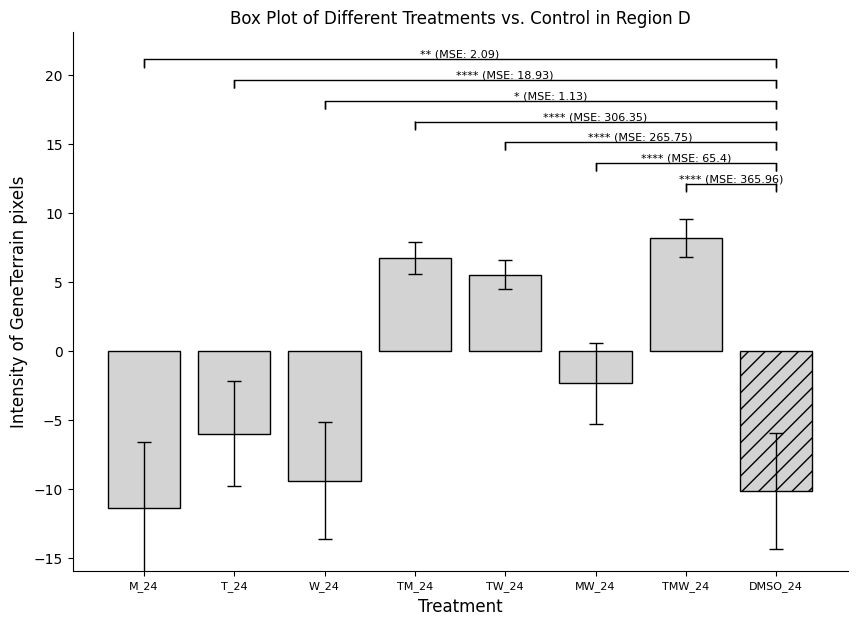

In [437]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'all_dht_data' and 'veh_data' are defined earlier in your code
# and 'positions', 'neutral_color', 'pval1', 'mse_values', 'ymin' are also predefined

# Generating mean and standard deviation for each group for the bar chart
mean_dht_data = [np.mean(dht) for dht in all_dht_data]
std_dht_data = [np.std(dht, ddof=1) for dht in all_dht_data]  # Using sample standard deviation
mean_veh_data = np.mean(veh_data)
std_veh_data = np.std(veh_data, ddof=1)  # Using sample standard deviation

# Set the background to white
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Create a new figure with adjusted size
plt.figure(figsize=(10, 7))

# Adjusting positions to match the number of DHT groups plus the VEH group
# Assuming 'positions' is a list of positions for each group
bar_positions_dht = positions[:-1]  # Use all but the last position for DHT groups
bar_positions_veh = positions[-1]  # Use the last position for the VEH group

# Plot bars for DHT groups
plt.bar(bar_positions_dht, mean_dht_data, yerr=std_dht_data, color=neutral_color, capsize=5, edgecolor='black', error_kw=dict(elinewidth=1, ecolor='black'))

# Plot bar for VEH group as a single bar, turning mean and std into lists to match the expected format
plt.bar([bar_positions_veh], [mean_veh_data], yerr=[std_veh_data], color=neutral_color, capsize=5, edgecolor='black', hatch="//", error_kw=dict(elinewidth=1, ecolor='black'))
# Adding the significance annotations for p-values
ymax = max(mean_dht_data + [mean_veh_data]) + max(std_dht_data + [std_veh_data]) + 0.1

# Draw horizontal lines for each p-value annotation
for i, p_value in enumerate(pval1, 1):
    y_line = ymax + 8 + (1-i)*1.5  # increment y position for each line to avoid overlap
    plt.text((positions[i-1]+positions[-1])/2, y_line, p_value+ ' (MSE: '+str(np.round(mse_values[i-1],2))+')', ha='center', va='bottom', fontsize=8)
    plt.plot([i, 8], [y_line, y_line], color="black", lw=1)
    plt.plot([i, i], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

    plt.plot([positions[-1], positions[-1]], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

# Additional plot adjustments
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set axis labels with a larger font size
plt.xticks(positions, ['M_24','T_24','W_24','TM_24','TW_24', 'MW_24', 'TMW_24',  'DMSO_24'], fontsize=8)
plt.ylabel('Intensity of GeneTerrain pixels', fontsize=12)
plt.ylim(ymin+5, ymax +10)  # Adjust the y-axis limit to accommodate annotation
plt.rcParams['figure.facecolor'] = 'white'
plt.xlabel('Treatment', fontsize=12,)
plt.title("Box Plot of Different Treatments vs. Control in Region D")
plt.rcParams['axes.facecolor'] = 'white'
# Show the plot with the adjusted style
plt.show()


In [438]:
intensity_24_TM_DMSO=[]

mat = outGT[29, :]
mat = mat.reshape(200, 200)
intensity_24_TM_DMSO.append(mat[labels_im==1])
mat = outGT[5, :]
mat = mat.reshape(200, 200)
intensity_24_TM_DMSO.append(mat[labels_im==1])

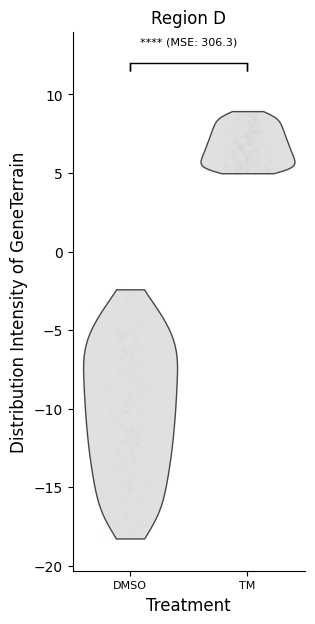

In [439]:
all_dht_data = intensity_24_TM_DMSO[1:]

veh_data=intensity_24_TM_DMSO[0]
p_values = [ttest_ind(dht_data, veh_data).pvalue for dht_data in all_dht_data]
# Calculate p-values for comparisons (using a simple t-test here for the example)

# Assuming all_dht_data is a list of arrays and veh_data is an array
mse_values = [mean_squared_error(dht_data, veh_data) for dht_data in all_dht_data]

# Set style to a neutral color for the plot
#plt.style.use('seaborn-whitegrid')

plt.style.use('default')
#plt.style.use('ggplot')

# Customize colors of the violin plots to neutral

neutral_color = '#D3D3D3'  # A common neutral color (light gray)

# Create a new figure with adjusted size
plt.figure(figsize=(3, 7))

# Create violin plots for each DHT group and the VEH group
positions = [1, 2]  # Positions on the x-axis
vp = plt.violinplot(all_dht_data + [veh_data], positions=positions, widths=0.8, showmeans=False, showmedians=False, showextrema=False)

# Customize colors of the violin plots to neutral
for pc in vp['bodies']:
    pc.set_facecolor(neutral_color)
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Adding scatter for the actual data points with smaller size
#scatter_positions = np.repeat(positions, [len(d) for d in all_dht_data] + [len(veh_data)])
scatter_data = np.concatenate(all_dht_data + [veh_data])
#plt.scatter(scatter_positions, scatter_data, color='black', alpha=0.2, s=1)
ax = plt.gca()

for i, data in enumerate(all_dht_data + [veh_data], 1):

    y = data

    x = np.random.normal(i, 0.1, size=len(y))

    ax.plot(x, y, 'k.', alpha=0.005)
# Remove top and right axis lines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adding the significance annotations for p-values and lines for more clarification
ymax = max(scatter_data) + 0.05
ymin = min(scatter_data) - 0.05
pval1=[]
for pval in p_values:
  if pval < 0.00001:
    pval = '****'
  elif pval < 0.0001:
    pval = '***'
  elif pval < 0.001:
    pval = '**'
  elif pval < 0.05:
    pval = '*'
  else:
     pval = 'ns'
  pval1.append(pval)
# Draw horizontal lines for each p-value annotation
for i, p_value in enumerate(pval1, 1):
    y_line = ymax + 3 + (1-i)*4  # increment y position for each line to avoid overlap
    plt.text((positions[i-1]+positions[-1])/2, round(y_line)+1, p_value+ ' (MSE: '+str(np.round(mse_values[i-1],1))+')', ha='center', va='bottom', fontsize=8)
    plt.plot([i, 2], [y_line, y_line], color="black", lw=1)
    plt.plot([i, i], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

    plt.plot([positions[-1], positions[-1]], [y_line - 0.01, y_line + 0.01], color="black", lw=.05, marker=3)

# Set axis labels with a larger font size
plt.xticks(positions, ['DMSO','TM'], fontsize=8)
plt.ylabel('Distribution Intensity of GeneTerrain', fontsize=12)
plt.ylim(ymin-2, ymax + 5)  # Adjust the y-axis limit to accommodate annotation
plt.rcParams['figure.facecolor'] = 'white'
plt.xlabel('Treatment', fontsize=12,)
plt.title("Region D")
plt.rcParams['axes.facecolor'] = 'white'
# Show the plot with the adjusted style
plt.show()

In [440]:
intensity_24=pd.DataFrame(intensity_24).T
intensity_24.columns=['DMSO_24','M_24','T_24','W_24','TM_24','TW_24','MW_24','TMW_24']

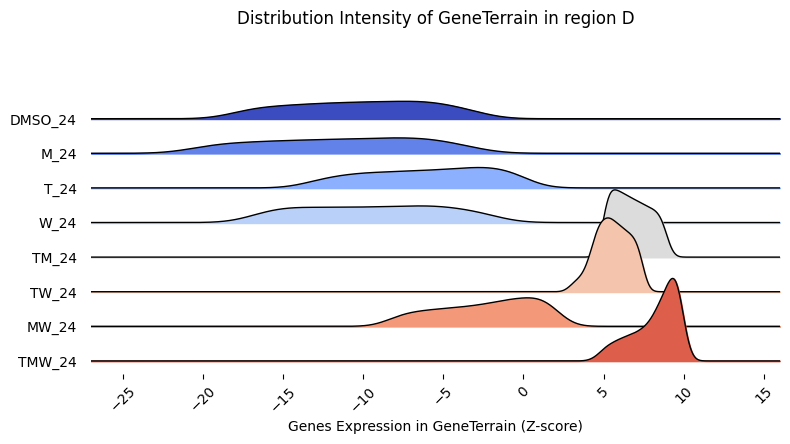

In [441]:
# Create the ridgeline plot
fig, axes = joyplot(
    intensity_24,
    colormap = cm.coolwarm,
    linewidth = 1,
    figsize=(8, 4),
    grid = False,


)

# Customize the plot
plt.xlabel("Genes Expression in GeneTerrain (Z-score)")
plt.ylabel("Treatment")
plt.title("Distribution Intensity of GeneTerrain in region D")



# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()